In [1]:
import os 
import warnings
import pickle

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

if not os.path.exists("figures"):
    os.mkdir("figures")


In [2]:
if not os.path.exists("figures"):
    os.mkdir("figures")

In [3]:
def get_results_table(use_test, preprocess_type, hpo, metric, model_names, eval_type="performance"):

    mean_val_perf = {}
    for dataset_name in dataset_names:
        mean_val_perf[dataset_name] = {}
        if dataset_name=="ieee-fraud-detection":
            n_folds = 6
        else:
            n_folds = 10
            
        for model_name in model_names:
            # print(dataset_name,model_name)
            try:
                if metric == "val":
                    perf = np.mean([results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name][hpo]["performance"]["Val"][f"fold_{i}"] for i in range(n_folds)])
                
                else:
                    perf = results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name][hpo][eval_type]["Test"][metric]
                # else:
                #     perf = np.nan
                # if dataset_name=="santander-value-prediction-challenge":
                    # perf *=-1
                    # perf /=10
            except:
                perf = np.nan
            if dataset_name in ["santander-value-prediction-challenge", "otto-group-product-classification-challenge", "bnp-paribas-cardif-claims-management"] and metric in ["private_score","public_score"]:
                mean_val_perf[dataset_name][model_name] = 1-perf
            else:
                mean_val_perf[dataset_name][model_name] = perf
    df = pd.DataFrame(mean_val_perf).transpose()
    return df    


In [4]:
exp_name="neurips24"
seed = 42

dataset_names = ['mercedes-benz-greener-manufacturing',
       'santander-value-prediction-challenge',
       'amazon-employee-access-challenge',
       'otto-group-product-classification-challenge',
       'santander-customer-satisfaction',
       'bnp-paribas-cardif-claims-management',
       'santander-customer-transaction-prediction', 
       "homesite-quote-conversion",
       'ieee-fraud-detection',
       'porto-seguro-safe-driver-prediction',
                ] 
model_names = ["XGBoost", "LightGBM", "CatBoost", "ResNet", "FTTransformer", "MLP-PLR", "GRANDE"]
preprocess_types = ["expert", 'minimalistic']
seed = 42

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore")

results = {}

for dataset_name in dataset_names:
    results[dataset_name] = {}
    for preprocess_type in preprocess_types:
        results[dataset_name][preprocess_type] = {}
        for use_test in [False, True]:
            results[dataset_name][preprocess_type][f"use_test_{use_test}"] = {}
            for model_name in model_names:
                results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name] = {}
                for tune in [False, True]:
                    if use_test:
                        exp_name_use = exp_name+"_test"
                    else:
                        exp_name_use = exp_name+"_notest"
                    if tune:
                        exp_name_use += "_tuned"


                    
                    ### Conditions
                    # Minimalistic preprocessing only has relevant distinction for use_test when numerical features are present - can skip it
                    if preprocess_type == "minimalistic" and use_test:
                        if not tune:
                            results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["default"] = {}
                        else:
                            results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["hpo"] = {}
                        continue
    
                    # First check on default whether there is a difference
                    # if use_test and tune:
                    #     continue
                    
                    try:
                        if not tune:
                           if use_test and dataset_name in ["mercedes-benz-greener-manufacturing", "santander-value-prediction-challenge", "bnp-paribas-cardif-claims-management", "homesite-quote-conversion"]:
                                exp_name_use = exp_name+"_notest"
                                with open(f'./results/{dataset_name}/{preprocess_type}/{model_name}/{exp_name_use}/{exp_name_use}_seed{seed}.pickle', 'rb') as handle:
                                    exp_results = pickle.load(handle)
                                results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["hpo"] = exp_results                    
                           else:
                               with open(f'./results/{dataset_name}/{preprocess_type}/{model_name}/{exp_name_use}/{exp_name_use}_seed{seed}.pickle', 'rb') as handle:
                                   exp_results = pickle.load(handle)
                               results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["default"] = exp_results
                        else:
                            # No operations that change how expert preprocessing is done betwen use_test True/False
                            if use_test and dataset_name in ["mercedes-benz-greener-manufacturing", "santander-value-prediction-challenge", "bnp-paribas-cardif-claims-management", "homesite-quote-conversion"]:
                                exp_name_use = exp_name+"_notest_tuned"
                                with open(f'./results/{dataset_name}/{preprocess_type}/{model_name}/{exp_name_use}/{exp_name_use}_seed{seed}.pickle', 'rb') as handle:
                                    exp_results = pickle.load(handle)
                                results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["hpo"] = exp_results                    

                            # Standard procedure
                            else:                            
                                with open(f'./results/{dataset_name}/{preprocess_type}/{model_name}/{exp_name_use}/{exp_name_use}_seed{seed}.pickle', 'rb') as handle:
                                    exp_results = pickle.load(handle)
                                results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["hpo"] = exp_results                    
                        print(f"Load {model_name} with tune={tune} on dataset {dataset_name} with {preprocess_type} preprocessing and use_test={use_test}")
                        # try:
                        #     if (n_trials is not None) and (model_name != "AutoGluon"):
                        #         exp_name_use = exp_name+"_tuned"
                        #     else:
                        #         exp_name_use = exp_name                            
                        #     sub = pd.read_csv(f"./results/{dataset_name}/submissions/{model_name}_{preprocess_type}_{exp_name_use}.csv")
                        # except:
                        #     print("No submission file found!")
                        
                    except:
                        print("----------------------------------------------")
                        print(f"Results not available for {model_name} with tune={tune} on dataset {dataset_name} with {preprocess_type} preprocessing and use_test={use_test}")
                        print("----------------------------------------------")
                        if not tune:
                            results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["default"] = {}
                        else:
                            results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["hpo"] = {}

Load XGBoost with tune=False on dataset mercedes-benz-greener-manufacturing with expert preprocessing and use_test=False
Load XGBoost with tune=True on dataset mercedes-benz-greener-manufacturing with expert preprocessing and use_test=False
Load LightGBM with tune=False on dataset mercedes-benz-greener-manufacturing with expert preprocessing and use_test=False
Load LightGBM with tune=True on dataset mercedes-benz-greener-manufacturing with expert preprocessing and use_test=False
Load CatBoost with tune=False on dataset mercedes-benz-greener-manufacturing with expert preprocessing and use_test=False
Load CatBoost with tune=True on dataset mercedes-benz-greener-manufacturing with expert preprocessing and use_test=False
Load ResNet with tune=False on dataset mercedes-benz-greener-manufacturing with expert preprocessing and use_test=False
Load ResNet with tune=True on dataset mercedes-benz-greener-manufacturing with expert preprocessing and use_test=False
Load FTTransformer with tune=False

In [5]:
import joblib
from itertools import product
from datasets import get_dataset
for model_name in model_names:
    for data_config in product(dataset_names,preprocess_types,[False, True]): 
        dataset_name, preprocess_type, use_test = data_config
        dataset = get_dataset(dataset_name)
        if use_test:
            exp_name_use = exp_name+"_test"
            exp_name_use_study = exp_name+"_test"
        else:
            exp_name_use = exp_name+"_notest"
            exp_name_use_study = exp_name+"_notest"
        exp_name_use += "_tuned"

        if dataset.eval_metric_name in ["mse","rmse","rmsle","logloss","mlogloss","multilabel"]:
            direction = "minimize"
        else:
            direction = "maximize"

        
        if preprocess_type == "minimalistic" and use_test:
            results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["hpo"]["performance_oneconfig"] = {}
            public_score, private_score, public_rank, public_percentile, private_rank, private_percentile = [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
        elif use_test and dataset_name in ["mercedes-benz-greener-manufacturing", "santander-value-prediction-challenge", "bnp-paribas-cardif-claims-management", "homesite-quote-conversion"]:
            # print("!!!")
            results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["hpo"]["performance_oneconfig"] = {}
            public_score, private_score, public_rank, public_percentile, private_rank, private_percentile = [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
        else:
            results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["hpo"]["performance_oneconfig"] = {}        
                    
            use_test = str(use_test)
            if os.path.exists(f'results/{dataset_name}/{preprocess_type}/{model_name}/{exp_name_use}/{exp_name_use}_oneconfig.pickle'):
                print(f"Results already exist: {f'results/{dataset_name}/{preprocess_type}/{model_name}/{exp_name_use}/{exp_name_use}_oneconfig.pickle'}.")
                with open(f'results/{dataset_name}/{preprocess_type}/{model_name}/{exp_name_use}/{exp_name_use}_oneconfig.pickle', 'rb') as handle:
                    public_score, private_score, public_rank, public_percentile, private_rank, private_percentile = pickle.load(handle)
            else:    
                try:
                    # print(f"Get HPO results for {model_name} with tune={tune} on dataset {dataset_name} with {preprocess_type} preprocessing and use_test={use_test}")
                    if dataset_name in ["ieee-fraud-detection"]:
                        n_folds = 6
                    # elif dataset_name in ["porto-seguro-safe-driver-prediction"] and preprocess_type=="minimalistic":
                    #     n_folds = 5
                    else:
                        n_folds = 10
                    
                    save_path = f'results/{dataset_name}/{preprocess_type}/{model_name}'
                    values = []
                    predictions = []
                    for num_fold in range(n_folds):
                        fold_string = f"fold_{num_fold}"
                        study = joblib.load(f'{save_path}/{exp_name_use}/{fold_string}/{exp_name_use_study}_study.pkl')
                        trials = study.get_trials()
    
                        # Workaround for some failed trials (only porto fe/tta for FTT)
                        n_trials = len(trials)
                        if n_trials<100:
                           n_trials=50
                           n_trials_min = 50 
                        else:
                           n_trials_min = 100 
                        # print(study.best_trial.values,study.best_trial.params)
                        if direction =="maximize":
                            values.append([trials[i].values[0] if trials[i].values is not None else -np.inf for i in range(n_trials)])
                        elif direction =="minimize":
                            values.append([trials[i].values[0] if trials[i].values is not None else np.inf for i in range(n_trials)])
                        predictions.append([trials[i].user_attrs["predictions"] for i in range(n_trials)])
                    values = np.array([i[:n_trials_min] for i in values])
                    # print(f"{model_name} with tune={tune} on dataset {dataset_name} with {preprocess_type} preprocessing and use_test={use_test}:")
                    failed = np.logical_or(values==np.inf,values==-np.inf)
                    # print(f"{failed.sum()} trials failed, fold with highest no. of failures: {failed.sum(axis=1).max()}, config with highest no. of failures: {failed.sum(axis=0).max()}")
                    # print("----------------------------------------------")
                # Default
    
                    # print(f"Get one config results for {model_name} with tune={tune} on dataset {dataset_name} with {preprocess_type} preprocessing and use_test={use_test}")
                    n_folds = len(predictions)    
                    
                    if direction=="maximize":
                        best_average_predictions = np.mean([predictions[num_fold][values.mean(axis=0).argmax()][2] for num_fold in range(n_folds)], axis=0)
                    else:
                        best_average_predictions = np.mean([predictions[num_fold][values.mean(axis=0).argmin()][2] for num_fold in range(n_folds)], axis=0)
                        
                    submission = dataset.pred_to_submission(best_average_predictions)
                        
                    save_name = f'results/{dataset_name}/{preprocess_type}/{model_name}/{exp_name_use}/{model_name}_{preprocess_type}_{exp_name_use}_oneconfig.csv'
                    submission.to_csv(save_name,index=False)        
                    oneconfig_res = dataset.submit_data(save_name)
                        
                    with open(f'results/{dataset_name}/{preprocess_type}/{model_name}/{exp_name_use}/{exp_name_use}_oneconfig.pickle', 'wb') as handle:
                        pickle.dump(oneconfig_res, handle, protocol=pickle.HIGHEST_PROTOCOL)
                    public_score, private_score, public_rank, public_percentile, private_rank, private_percentile = oneconfig_res
                    print(f"Successfull: {model_name} with tune={tune} on dataset {dataset_name} with {preprocess_type} preprocessing and use_test={use_test}")
                    
                except:
                    print(f"Something gone wrong with {model_name}, {data_config} not available")
                    # print("----------------------------------------------")
                    public_score, private_score, public_rank, public_percentile, private_rank, private_percentile = [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
            
        results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["hpo"]["performance_oneconfig"]["Test"] = {
                  "public_score": public_score, 
                  "private_score": private_score, 
                  "public_rank": public_rank, 
                  "public_percentile": public_percentile, 
                  "private_rank": private_rank, 
                  "private_percentile": private_percentile
                 }
        print(results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["hpo"]["performance_oneconfig"]["Test"])
        print("---------------------------------------------------")
        


2024-06-12 11:42:25.745192: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 11:42:27.289799: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Results already exist: results/mercedes-benz-greener-manufacturing/expert/XGBoost/neurips24_notest_tuned/neurips24_notest_tuned_oneconfig.pickle.
{'public_score': 0.55804, 'private_score': 0.55363, 'public_rank': 1729, 'public_percentile': 0.45214435146443516, 'private_rank': 25, 'private_percentile': 0.00653765690376569}
---------------------------------------------------
{'public_score': nan, 'private_score': nan, 'public_rank': nan, 'public_percentile': nan, 'private_rank': nan, 'private_percentile': nan}
---------------------------------------------------
Results already exist: results/mercedes-benz-greener-manufacturing/minimalistic/XGBoost/neurips24_notest_tuned/neurips24_notest_tuned_oneconfig.pickle.
{'public_score': 0.55078, 'private_score': 0.54784, 'public_rank': 2576, 'public_percentile': 0.6736401673640168, 'private_rank': 1603, 'private_percentile': 0.41919456066945604}
---------------------------------------------------
{'public_score': nan, 'private_score': nan, 'public

In [6]:
### Investigate Performance after random search
import joblib
from itertools import product
from datasets import get_dataset
for model_name in model_names:
    for data_config in product(dataset_names,preprocess_types,[False, True]): 
        dataset_name, preprocess_type, use_test = data_config
        dataset = get_dataset(dataset_name)
        if use_test:
            exp_name_use = exp_name+"_test"
            exp_name_use_study = exp_name+"_test"
        else:
            exp_name_use = exp_name+"_notest"
            exp_name_use_study = exp_name+"_notest"
        exp_name_use += "_tuned"

        if dataset.eval_metric_name in ["mse","rmse","rmsle","logloss","mlogloss","multilabel"]:
            direction = "minimize"
        else:
            direction = "maximize"

        
        if preprocess_type == "minimalistic" and use_test:
            results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["hpo"]["performance_20trials"] = {}
            public_score, private_score, public_rank, public_percentile, private_rank, private_percentile = [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
        elif use_test and dataset_name in ["mercedes-benz-greener-manufacturing", "santander-value-prediction-challenge", "bnp-paribas-cardif-claims-management", "homesite-quote-conversion"]:
            # print("!!!")
            results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["hpo"]["performance_20trials"] = {}
            public_score, private_score, public_rank, public_percentile, private_rank, private_percentile = [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
        else:
            results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["hpo"]["performance_20trials"] = {}        
                    
            use_test = str(use_test)
            if os.path.exists(f'results/{dataset_name}/{preprocess_type}/{model_name}/{exp_name_use}/{exp_name_use}_20trials.pickle'):
                print(f"Results already exist: {f'results/{dataset_name}/{preprocess_type}/{model_name}/{exp_name_use}/{exp_name_use}_oneconfig.pickle'}.")
                with open(f'results/{dataset_name}/{preprocess_type}/{model_name}/{exp_name_use}/{exp_name_use}_20trials.pickle', 'rb') as handle:
                    public_score, private_score, public_rank, public_percentile, private_rank, private_percentile = pickle.load(handle)
            else:    
                try:
                    # print(f"Get HPO results for {model_name} with tune={tune} on dataset {dataset_name} with {preprocess_type} preprocessing and use_test={use_test}")
                    if dataset_name in ["ieee-fraud-detection"]:
                        n_folds = 6
                    # elif dataset_name in ["porto-seguro-safe-driver-prediction"] and preprocess_type=="minimalistic":
                    #     n_folds = 5
                    else:
                        n_folds = 10
                    
                    save_path = f'results/{dataset_name}/{preprocess_type}/{model_name}'
                    values = []
                    predictions = []
                    for num_fold in range(n_folds):
                        fold_string = f"fold_{num_fold}"
                        study = joblib.load(f'{save_path}/{exp_name_use}/{fold_string}/{exp_name_use_study}_study.pkl')
                        trials = study.get_trials()
                        # print(study.best_trial.values,study.best_trial.params)
                        if direction =="maximize":
                            values.append([trials[i].values[0] if trials[i].values is not None else -np.inf for i in range(20)])
                        elif direction =="minimize":
                            values.append([trials[i].values[0] if trials[i].values is not None else np.inf for i in range(20)])
                        predictions.append([trials[i].user_attrs["predictions"] for i in range(20)])
                    values = np.array(values)
    
                    n_folds = len(predictions)
                    test_preds = np.array([[preds[2] for preds in predictions[num_fold][:20]] for num_fold in range(len(predictions))])
                    if direction=="maximize":
                        trial_20_preds = np.mean([test_preds[num_fold][values[num_fold,:20].argmax()] for num_fold in range(len(predictions))],axis=0)
                    else:
                        trial_20_preds = np.mean([test_preds[num_fold][values[num_fold,:20].argmin()] for num_fold in range(len(predictions))],axis=0)
                        
                    dataset = get_dataset(dataset_name)
                    submission = dataset.pred_to_submission(trial_20_preds)
                    
                    save_name = f'results/{dataset_name}/{preprocess_type}/{model_name}/{exp_name_use}/{model_name}_{preprocess_type}_{exp_name_use}_20trials.csv'
                    submission.to_csv(save_name,index=False)        
                    trials_20_res = dataset.submit_data(save_name)
                    
                    with open(f'results/{dataset_name}/{preprocess_type}/{model_name}/{exp_name_use}/{exp_name_use}_20trials.pickle', 'wb') as handle:
                        pickle.dump(trials_20_res, handle, protocol=pickle.HIGHEST_PROTOCOL)
                    
                    public_score, private_score, public_rank, public_percentile, private_rank, private_percentile = trials_20_res
    
                    print(f"Successfull: {model_name} with tune={tune} on dataset {dataset_name} with {preprocess_type} preprocessing and use_test={use_test}")
                
                except:
                    print(f"Something gone wrong with {model_name}, {data_config} not available")
                    # print("----------------------------------------------")
                    public_score, private_score, public_rank, public_percentile, private_rank, private_percentile = [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
            
        results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["hpo"]["performance_20trials"]["Test"] = {
                  "public_score": public_score, 
                  "private_score": private_score, 
                  "public_rank": public_rank, 
                  "public_percentile": public_percentile, 
                  "private_rank": private_rank, 
                  "private_percentile": private_percentile
                 }
        print(results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["hpo"]["performance_20trials"]["Test"])
        print("---------------------------------------------------")
        


Results already exist: results/mercedes-benz-greener-manufacturing/expert/XGBoost/neurips24_notest_tuned/neurips24_notest_tuned_oneconfig.pickle.
{'public_score': 0.55987, 'private_score': 0.55341, 'public_rank': 1566, 'public_percentile': 0.40951882845188287, 'private_rank': 34, 'private_percentile': 0.00889121338912134}
---------------------------------------------------
{'public_score': nan, 'private_score': nan, 'public_rank': nan, 'public_percentile': nan, 'private_rank': nan, 'private_percentile': nan}
---------------------------------------------------
Results already exist: results/mercedes-benz-greener-manufacturing/minimalistic/XGBoost/neurips24_notest_tuned/neurips24_notest_tuned_oneconfig.pickle.
{'public_score': 0.55266, 'private_score': 0.54741, 'public_rank': 2374, 'public_percentile': 0.62081589958159, 'private_rank': 1713, 'private_percentile': 0.4479602510460251}
---------------------------------------------------
{'public_score': nan, 'private_score': nan, 'public_ra

In [7]:
metric = "private_percentile"
df_min_def = 1-get_results_table(use_test=False, preprocess_type="minimalistic", hpo="default", metric=metric, model_names=model_names, eval_type="performance")
df_fe_def = 1-get_results_table(use_test=False, preprocess_type="expert", hpo="default", metric=metric, model_names=model_names, eval_type="performance")
df_tta_def = 1-get_results_table(use_test=True, preprocess_type="expert", hpo="default", metric=metric, model_names=model_names, eval_type="performance")

df_min_light = 1-get_results_table(use_test=False, preprocess_type="minimalistic", hpo="hpo", metric=metric, model_names=model_names, eval_type="performance_20trials")
df_fe_light = 1-get_results_table(use_test=False, preprocess_type="expert", hpo="hpo", metric=metric, model_names=model_names, eval_type="performance_20trials")
df_tta_light = 1-get_results_table(use_test=True, preprocess_type="expert", hpo="hpo", metric=metric, model_names=model_names, eval_type="performance_20trials")

df_min_extensive = 1-get_results_table(use_test=False, preprocess_type="minimalistic", hpo="hpo", metric=metric, model_names=model_names, eval_type="performance")
df_fe_extensive = 1-get_results_table(use_test=False, preprocess_type="expert", hpo="hpo", metric=metric, model_names=model_names, eval_type="performance")
df_tta_extensive = 1-get_results_table(use_test=True, preprocess_type="expert", hpo="hpo", metric=metric, model_names=model_names, eval_type="performance")

df_min_extensive_ens = 1-get_results_table(use_test=False, preprocess_type="minimalistic", hpo="hpo", metric=metric, model_names=model_names, eval_type="performance_ens")
df_fe_extensive_ens = 1-get_results_table(use_test=False, preprocess_type="expert", hpo="hpo", metric=metric, model_names=model_names, eval_type="performance_ens")
df_tta_extensive_ens = 1-get_results_table(use_test=True, preprocess_type="expert", hpo="hpo", metric=metric, model_names=model_names, eval_type="performance_ens")

df_min_extensive_oneconfig = 1-get_results_table(use_test=False, preprocess_type="minimalistic", hpo="hpo", metric=metric, model_names=model_names, eval_type="performance_oneconfig")
df_fe_extensive_oneconfig = 1-get_results_table(use_test=False, preprocess_type="expert", hpo="hpo", metric=metric, model_names=model_names, eval_type="performance_oneconfig")
df_tta_extensive_oneconfig = 1-get_results_table(use_test=True, preprocess_type="expert", hpo="hpo", metric=metric, model_names=model_names, eval_type="performance_oneconfig")

df_tta_def.loc[["mercedes-benz-greener-manufacturing", "santander-value-prediction-challenge", "bnp-paribas-cardif-claims-management", "homesite-quote-conversion"]] = df_fe_def.loc[["mercedes-benz-greener-manufacturing", "santander-value-prediction-challenge", "bnp-paribas-cardif-claims-management", "homesite-quote-conversion"]]
df_tta_light.loc[["mercedes-benz-greener-manufacturing", "santander-value-prediction-challenge", "bnp-paribas-cardif-claims-management", "homesite-quote-conversion"]] = df_fe_light.loc[["mercedes-benz-greener-manufacturing", "santander-value-prediction-challenge", "bnp-paribas-cardif-claims-management", "homesite-quote-conversion"]]

### Get AutoML results

In [8]:
exp_name="neurips24"
seed = 42

model_names_auto = ["AutoGluon"]
preprocess_types = [None]
seed = 42

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore")

for dataset_name in dataset_names:
    for preprocess_type in preprocess_types:
        if preprocess_type==None:
            preprocess_type = "None"
            results[dataset_name][preprocess_type] = {}
        for use_test in [False]:
            if preprocess_type=="None":
                results[dataset_name][preprocess_type][f"use_test_{use_test}"] = {}
            for model_name in model_names_auto:
                results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name] = {}
                exp_name_use = exp_name

                
                ### Conditions
                # Minimalistic preprocessing only has relevant distinction for use_test when numerical features are present - can skip it
                if preprocess_type == "minimalistic" and use_test:
                    continue
                
                try:
                    with open(f'./results/{dataset_name}/{preprocess_type}/{model_name}/{exp_name}/{exp_name}_seed{seed}.pickle', 'rb') as handle:
                        exp_results = pickle.load(handle)
                    results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["default"] = exp_results
                    print(f"Load {model_name} on dataset {dataset_name} with {preprocess_type} preprocessing")
                    
                except:
                    print("----------------------------------------------")
                    print(f"Results not available for {model_name} on dataset {dataset_name} with {preprocess_type} preprocessing")
                    print("----------------------------------------------")
                    results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["default"] = None


Load AutoGluon on dataset mercedes-benz-greener-manufacturing with None preprocessing
Load AutoGluon on dataset santander-value-prediction-challenge with None preprocessing
Load AutoGluon on dataset amazon-employee-access-challenge with None preprocessing
Load AutoGluon on dataset otto-group-product-classification-challenge with None preprocessing
Load AutoGluon on dataset santander-customer-satisfaction with None preprocessing
Load AutoGluon on dataset bnp-paribas-cardif-claims-management with None preprocessing
Load AutoGluon on dataset santander-customer-transaction-prediction with None preprocessing
Load AutoGluon on dataset homesite-quote-conversion with None preprocessing
Load AutoGluon on dataset ieee-fraud-detection with None preprocessing
Load AutoGluon on dataset porto-seguro-safe-driver-prediction with None preprocessing


In [9]:
exp_name="neurips24"
seed = 42

model_names_auto = ["AutoGluon"]
preprocess_types = ["expert"]
seed = 42

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore")

for dataset_name in dataset_names:
    for preprocess_type in preprocess_types:
        for use_test in [False, True]:
            for model_name in model_names_auto:
                results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name] = {}
                if use_test:
                    exp_name_use = exp_name+"_test"
                else:
                    exp_name_use = exp_name+"_notest"
                
                ### Conditions
                # Minimalistic preprocessing only has relevant distinction for use_test when numerical features are present - can skip it
                if preprocess_type == "minimalistic" and use_test:
                    continue
                
                try:
                    if use_test and dataset_name in ["mercedes-benz-greener-manufacturing", "santander-value-prediction-challenge", "bnp-paribas-cardif-claims-management", "homesite-quote-conversion"]:
                        results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["default"] = results[dataset_name][preprocess_type][f"use_test_False"][model_name]["default"]
                    else:
                        with open(f'./results/{dataset_name}/{preprocess_type}/{model_name}/{exp_name_use}/{exp_name}_seed{seed}.pickle', 'rb') as handle:
                            exp_results = pickle.load(handle)
                        results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["default"] = exp_results
                        print(f"Load {model_name} on dataset {dataset_name} with {preprocess_type} preprocessing")
                    
                except:
                    try:
                        with open(f'./results/{dataset_name}/{preprocess_type}/{model_name}/{exp_name_use}/{exp_name_use}_seed{seed}.pickle', 'rb') as handle:
                            exp_results = pickle.load(handle)
                        results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["default"] = exp_results
                        print(f"Load {model_name} on dataset {dataset_name} with {preprocess_type} preprocessing")
                    except:
                        print("----------------------------------------------")
                        print(f"Results not available for {model_name} on dataset {dataset_name} with {preprocess_type} preprocessing")
                        print("----------------------------------------------")
                        results[dataset_name][preprocess_type][f"use_test_{use_test}"][model_name]["default"] = None


Load AutoGluon on dataset mercedes-benz-greener-manufacturing with expert preprocessing
Load AutoGluon on dataset santander-value-prediction-challenge with expert preprocessing
Load AutoGluon on dataset amazon-employee-access-challenge with expert preprocessing
Load AutoGluon on dataset amazon-employee-access-challenge with expert preprocessing
Load AutoGluon on dataset otto-group-product-classification-challenge with expert preprocessing
Load AutoGluon on dataset otto-group-product-classification-challenge with expert preprocessing
Load AutoGluon on dataset santander-customer-satisfaction with expert preprocessing
Load AutoGluon on dataset santander-customer-satisfaction with expert preprocessing
Load AutoGluon on dataset bnp-paribas-cardif-claims-management with expert preprocessing
Load AutoGluon on dataset santander-customer-transaction-prediction with expert preprocessing
Load AutoGluon on dataset santander-customer-transaction-prediction with expert preprocessing
Load AutoGluon o

In [10]:
df_min_auto = 1-get_results_table(use_test=False, preprocess_type="None", hpo="default", metric="private_percentile", model_names=model_names_auto, eval_type="performance")
df_fe_auto = 1-get_results_table(use_test=False, preprocess_type="expert", hpo="default", metric="private_percentile", model_names=model_names_auto, eval_type="performance")
df_tta_auto = 1-get_results_table(use_test=True, preprocess_type="expert", hpo="default", metric="private_percentile", model_names=model_names_auto, eval_type="performance")


## Section 4, Figure 3: Overview of all results

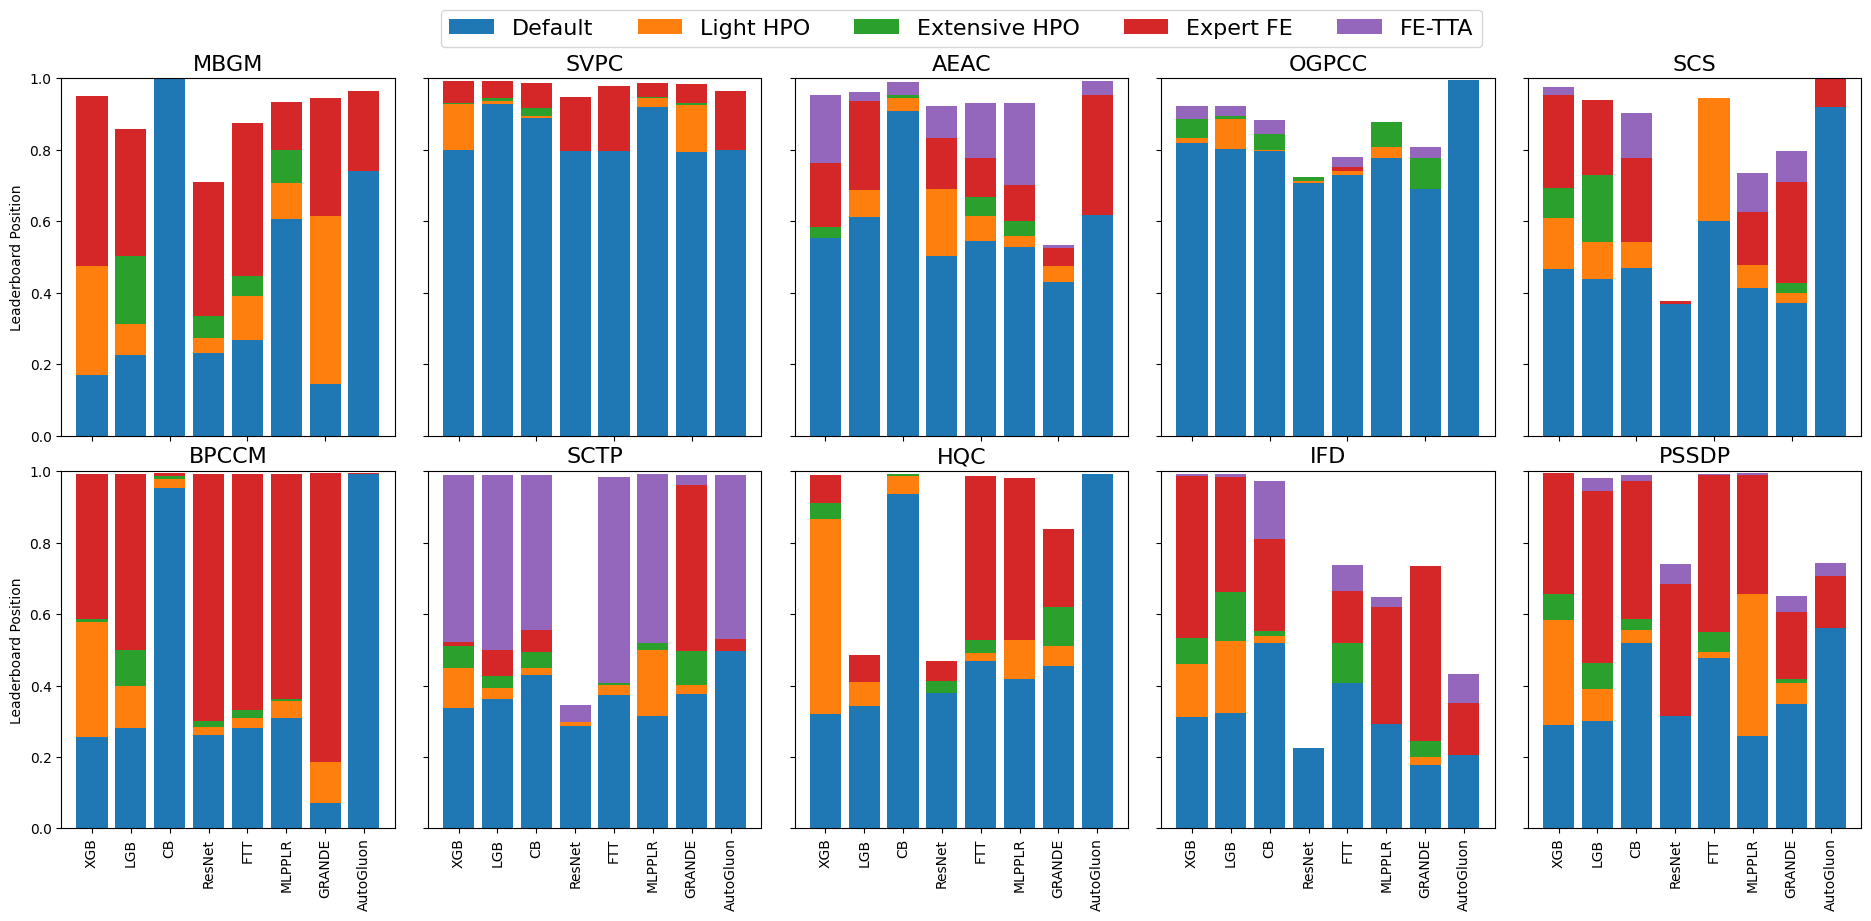

In [11]:
import matplotlib.pyplot as plt

model_map = {'XGBoost': "XGB", 'CatBoost': "CB", 'ResNet': 'ResNet', 'MLP-PLR': "MLPPLR", 'GRANDE': 'GRANDE', 'LightGBM': "LGB", "FTTransformer": "FTT", "AutoGluon": "AutoGluon"}
dataset_map = {'mercedes-benz-greener-manufacturing': "MBGM",
       'santander-value-prediction-challenge': "SVPC",
       'amazon-employee-access-challenge': "AEAC",
       'otto-group-product-classification-challenge': "OGPCC",
       'santander-customer-satisfaction': "SCS",
       'bnp-paribas-cardif-claims-management': "BPCCM",
       'santander-customer-transaction-prediction': "SCTP", 
       'homesite-quote-conversion': "HQC",
        'ieee-fraud-detection': "IFD",
       'porto-seguro-safe-driver-prediction': "PSSDP",
              }

# Set up the figure and axes
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

light_hpo = df_min_def - df_min_light
extensive_hpo = df_min_light - df_min_extensive
# cash = df_min_extensive - df_min_extensive["CatBoost"]
expert_fe = df_min_extensive - df_fe_extensive
fe_tta = df_fe_extensive - df_tta_extensive

df_min_light_extoverfitadjusted = df_min_light.copy()
df_min_light_extoverfitadjusted[(df_min_extensive-df_min_light)<0] = df_min_extensive[(df_min_extensive-df_min_light)<0]
df_min_light_extoverfitadjusted

# Set font sizes for LaTeX readability
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
# plt.rc('font', serif='Times New Roman')
plt.rc('font', size=14)
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=14)

# Create the bar plots
for i in range(10):  # datasets
    bottom = np.zeros(8)
    axes[i].bar(np.arange(8), np.maximum(0, pd.concat([df_min_def,df_min_auto],axis=1).iloc[i]), bottom=bottom, label='Default')
    bottom += np.maximum(0, pd.concat([df_min_def,df_min_auto],axis=1).iloc[i])
    axes[i].bar(np.arange(8), np.maximum(0, pd.concat([df_min_light_extoverfitadjusted,df_min_auto],axis=1).iloc[i] - bottom), bottom=bottom, label='Light HPO')
    bottom += np.maximum(0, pd.concat([df_min_light_extoverfitadjusted,df_min_auto],axis=1).iloc[i] - bottom)
    axes[i].bar(np.arange(8), np.maximum(0, pd.concat([df_min_extensive,df_min_auto],axis=1).iloc[i] - bottom), bottom=bottom, label='Extensive HPO')
    bottom += np.maximum(0, pd.concat([df_min_extensive,df_min_auto],axis=1).iloc[i] - bottom)
    axes[i].bar(np.arange(8), np.maximum(0, pd.concat([df_fe_extensive,df_fe_auto],axis=1).iloc[i] - bottom), bottom=bottom, label='Expert FE')
    bottom += np.maximum(0, pd.concat([df_fe_extensive,df_fe_auto],axis=1).iloc[i] - bottom)
    axes[i].bar(np.arange(8), np.maximum(0, pd.concat([df_tta_extensive,df_tta_auto],axis=1).iloc[i] - bottom), bottom=bottom, label='FE-TTA')
    # bottom += np.maximum(0, df_tta_extensive.iloc[i] - bottom)
    # axes[i].bar(np.arange(6), np.maximum(0, df_tta_extensive_ens.iloc[i] - bottom), bottom=bottom, label='Ensemble')
    
    axes[i].set_title(dataset_map[light_hpo.index[i]])
    
    if i % 5 == 0:  # Leftmost column
        axes[i].set_ylabel('Leaderboard Position')
        # axes[i].set_yticklabels([0.2,None,0.4,None,0.6,None,0.8,None,1.0])
    else:
        axes[i].set_yticklabels([])
    
    if i >= 5:  # Bottom row
        axes[i].set_xticks(np.arange(8))
        axes[i].set_xticklabels([model_map[mod] for mod in list(expert_fe.columns)+["AutoGluon"]], rotation=90)
    else:
        axes[i].set_xticklabels([])
    
    axes[i].set_ylim(0.0, 1.0)  # Adjust the y-axis limit to fit the data


# Create a single legend at the top of the figure
handles, labels = axes[5].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.03), fontsize=16)

# Adjust layout manually to prevent overlapping
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.2, wspace=0.1, hspace=0.1)

# Save the plot as a PDF file
plt.savefig('figures/all_results.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

plt.show()

### Subsection 4.1: How Model Comparisons Change

In [12]:
all_perf = pd.DataFrame([df_min_extensive.values.ravel(),df_fe_extensive.values.ravel(),df_tta_extensive.values.ravel()],index=["Standardized", "Expert FE", "FE-TTA"]).transpose()
spearman_corr = all_perf.corr("spearman")
spearman_corr

,Standardized,Expert FE,FE-TTA
Standardized,1.000000,0.430280,0.305411
Expert FE,0.430280,1.000000,0.778699
FE-TTA,0.305411,0.778699,1.000000


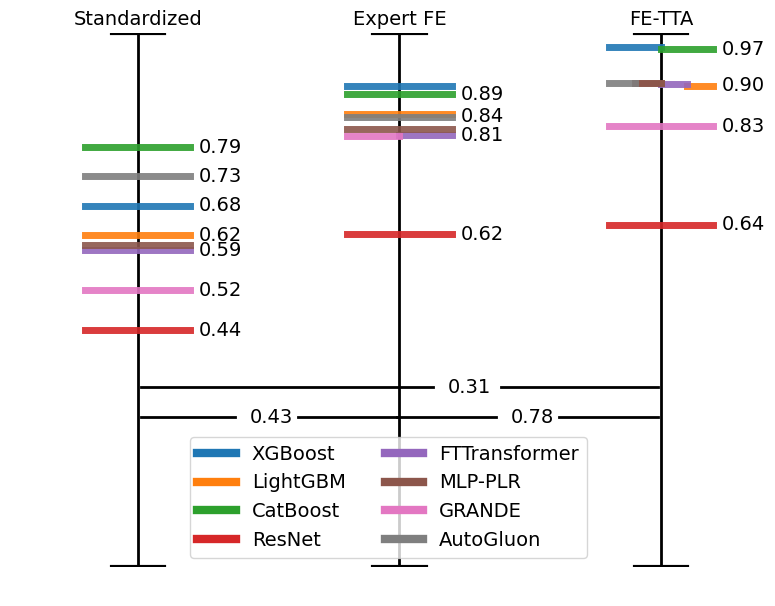

In [13]:
# Create a figure with one subplot per dataset
fig, axs = plt.subplots(1, 3, figsize=(9, 6))  # Adjust width as needed

y_labels = list(df_min_extensive.columns) + ["AutoGluon"]
colors = {i: j for i, j in zip(y_labels, ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f'])}

# Function to plot the data
def plot_data(ax, df,title):
    y_markers = list(np.mean(df,axis=0))
    # y_markers = list(np.median(df,axis=0))
    y_values = y_markers

    # Updated colors for publication
    ax.axvline(x=0, color='black', linestyle='-', linewidth=2)
    ax.axhline(y=0., color='black', linestyle='-', linewidth=3, xmin=0.35, xmax=0.65)
    ax.axhline(y=1., color='black', linestyle='-', linewidth=3, xmin=0.35, xmax=0.65)

    # Plot horizontal lines
    for y, label in zip(y_markers, y_labels):
        if title=="FE-TTA" and label=="CatBoost":
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=5, xmin=0.5, xmax=0.8, alpha=0.9)  # Set alpha for transparency
        elif title=="FE-TTA" and label=="XGBoost":
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=5, xmin=0.2, xmax=0.5, alpha=0.9)  # Set alpha for transparency
        elif title=="FE-TTA" and label=="AutoGluon":
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=5, xmin=0.2, xmax=0.35, alpha=0.9)  # Set alpha for transparency
        elif title=="FE-TTA" and label=="MLP-PLR":
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=5, xmin=0.35, xmax=0.5, alpha=1.0)  # Set alpha for transparency
        elif title=="FE-TTA" and label=="FTTransformer":
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=5, xmin=0.5, xmax=0.65, alpha=0.9)  # Set alpha for transparency
        elif title=="FE-TTA" and label=="LightGBM":
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=5, xmin=0.65, xmax=0.8, alpha=0.9)  # Set alpha for transparency
        elif title=="Expert FE" and label=="FTTransformer":
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=5, xmin=0.5, xmax=0.8, alpha=0.9)  # Set alpha for transparency
        elif title=="Expert FE" and label=="GRANDE":
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=5, xmin=0.2, xmax=0.5, alpha=0.9)  # Set alpha for transparency
        else:
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=5, xmin=0.2, xmax=0.8, alpha=0.9)  # Set alpha for transparency

    # Sort markers by their y-values
    sorted_markers = sorted(zip(y_markers, y_labels), key=lambda x: x[0])
    
    # Plot text for the highest value in case of overlap
    last_y = -float('inf')
    for y, label in sorted_markers:
        if y - last_y >= 0.02:  # Adjust threshold as needed to prevent overlap
            if label == "Best Expert Solution":
                ax.text(0.35, y, f'{y:.3f}', rotation=0, verticalalignment='center', horizontalalignment='left', fontsize=14, color='black')
            else:
                ax.text(0.35, y, f'{y:.2f}', rotation=0, verticalalignment='center', horizontalalignment='left', fontsize=14, color='black')
            last_y = y
    
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(0, 1)
    ax.tick_params(axis='y', direction='out', length=10, width=2, colors='black', grid_color='black', grid_alpha=0.5)
    ax.set_title(title, fontsize=14)



min = pd.concat([df_min_extensive, df_min_auto], axis=1)
fe = pd.concat([df_fe_extensive, df_fe_auto], axis=1)
tta = pd.concat([df_tta_extensive, df_tta_auto], axis=1)

# plot_data(axs[0], min, title="Standardized")
# plot_data(axs[1], np.max([min,fe],axis=0), title="Expert FE")
# plot_data(axs[2], np.max([min,fe,tta],axis=0), title="FE-TTA")

plot_data(axs[0], min, title="Standardized")
plot_data(axs[1], fe, title="Expert FE")
plot_data(axs[2], tta, title="FE-TTA")


# Add legend
handles = [plt.Line2D([0], [0], color=color, lw=6) for color in colors.values()]
labels = colors.keys()

# Move legend to the bottom closer to the plot
fig.legend(handles, labels, loc='lower center', ncol=int(len(colors)/3), fontsize=14, bbox_to_anchor=(0.5, 0.1))

# Add horizontal and vertical lines to separate the subplots
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

# Add Spearman correlation text
# correlation_text = f"Spearman Correlation\nStandardized vs Expert FE: {spearman_corr.iloc[0, 1]:.2f}\n" \
#                    f"Expert FE vs FE-TTA: {spearman_corr.iloc[1, 2]:.2f}\nStandardized vs FE-TTA: {spearman_corr.iloc[0, 2]:.2f}"
# fig.text(0.5, 0.9, correlation_text, ha='center', fontsize=14, bbox=dict(facecolor='white', alpha=0.5))

# Add spearman for standardized-fe
line_y = 0.35
fig.add_artist(plt.Line2D([0.225, 0.33], [line_y, line_y], color='black', linewidth=2))
fig.add_artist(plt.Line2D([0.40, 0.51], [line_y, line_y], color='black', linewidth=2))
fig.text(0.37, line_y-0.01, round(spearman_corr.loc["Standardized","Expert FE"],2), ha='center', fontsize=14)

# Add spearman for fe-tta
line_y = 0.35
fig.add_artist(plt.Line2D([0.51, 0.62], [line_y, line_y], color='black', linewidth=2))
fig.add_artist(plt.Line2D([0.69, 0.8], [line_y, line_y], color='black', linewidth=2))
fig.text(0.66, line_y-0.01, round(spearman_corr.loc["Expert FE","FE-TTA"],2), ha='center', fontsize=14)

# Add spearman for standardized-tta
line_y = 0.4
fig.add_artist(plt.Line2D([0.225, 0.55], [line_y, line_y], color='black', linewidth=2))
fig.add_artist(plt.Line2D([0.625, 0.8], [line_y, line_y], color='black', linewidth=2))
fig.text(0.59, line_y-0.01, round(spearman_corr.loc["Standardized","FE-TTA"],2), ha='center', fontsize=14)



# Adjust layout to make the plot narrower
plt.subplots_adjust(top=0.99, bottom=0.1, hspace=0.3, wspace=0.5)

plt.savefig('figures/pipeline_differences.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

# Display the combined plot
plt.show()

### Subsection 4.2: Progress in the field

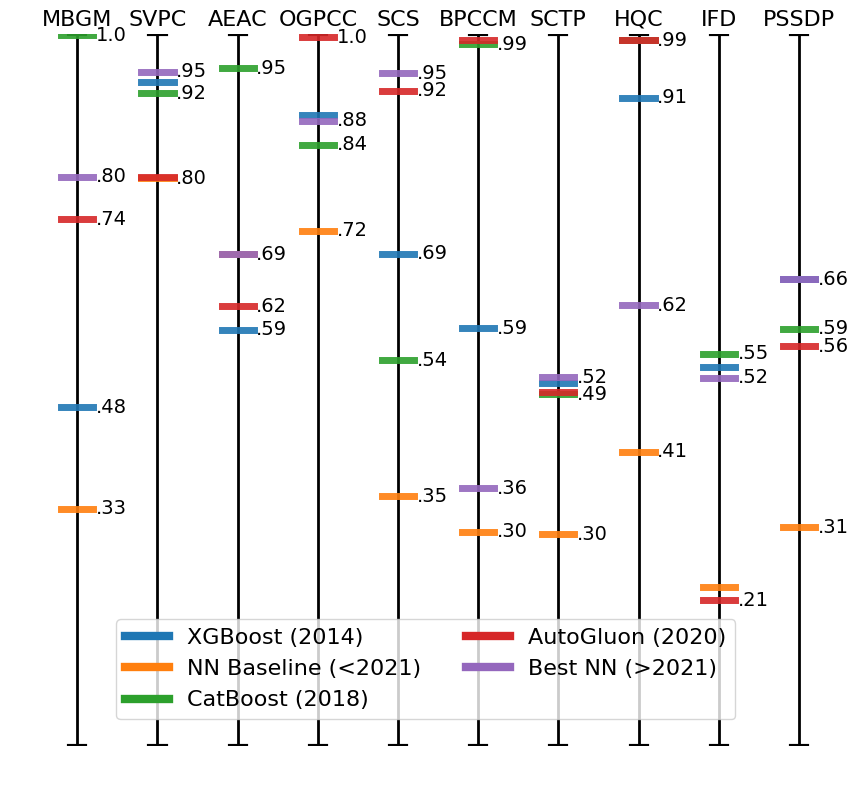

In [14]:
# Create a figure with one subplot per dataset
fig, axs = plt.subplots(1, len(dataset_names), figsize=(len(dataset_names), 8))  # Adjust width as needed

y_labels = ["XGBoost (2014)", "NN Baseline (<2021)", "CatBoost (2018)", "AutoGluon (2020)", "Best NN (>2021)"]#,"Top Expert Solution"]
colors = {i: j for i, j in zip(y_labels, ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])}


# Function to plot the data
def plot_data(ax, dataset_name):
    y_markers = [
        df_min_extensive.loc[dataset_name, "XGBoost"], 
        df_min_extensive.loc[dataset_name, "ResNet"], 
        df_min_extensive.loc[dataset_name, "CatBoost"],
        df_min_auto.loc[dataset_name, "AutoGluon"],
        df_min_extensive.loc[dataset_name, ["ResNet", "MLP-PLR", "FTTransformer", "GRANDE"]].max(),
        # best_per_dataset.loc[dataset_name]
    ]
    y_values = y_markers

    # Updated colors for publication
    ax.axvline(x=0, color='black', linestyle='-', linewidth=2)
    ax.axhline(y=0., color='black', linestyle='-', linewidth=3, xmin=0.35, xmax=0.65)
    ax.axhline(y=1., color='black', linestyle='-', linewidth=3, xmin=0.35, xmax=0.65)

    # Plot horizontal lines
    for y, label in zip(y_markers, y_labels):
        if dataset_name=="santander-value-prediction-challenge" and label=="AutoGluon":
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=6, xmin=0.2, xmax=0.5, alpha=0.9)  # Set alpha for transparency
        elif dataset_name=="santander-value-prediction-challenge" and label=="NN Baseline":
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=6, xmin=0.5, xmax=0.8, alpha=0.9)  # Set alpha for transparency
        elif dataset_name=="amazon-employee-access-challenge" and label=="NN Baseline":
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=6, xmin=0.2, xmax=0.5, alpha=0.9)  # Set alpha for transparency
        elif dataset_name=="amazon-employee-access-challenge" and label=="Best NN":
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=6, xmin=0.5, xmax=0.8, alpha=0.9)  # Set alpha for transparency
        elif dataset_name=="homesite-quote-conversion" and label=="AutoGluon":
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=6, xmin=0.2, xmax=0.5, alpha=0.9)  # Set alpha for transparency
        elif dataset_name=="homesite-quote-conversion" and label=="CatBoost":
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=6, xmin=0.5, xmax=0.8, alpha=0.9)  # Set alpha for transparency
        elif dataset_name=="porto-seguro-safe-driver-prediction" and label=="Best NN":
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=6, xmin=0.2, xmax=0.5, alpha=0.9)  # Set alpha for transparency
        elif dataset_name=="porto-seguro-safe-driver-prediction" and label=="XGBoost":
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=6, xmin=0.5, xmax=0.8, alpha=0.9)  # Set alpha for transparency
        else:
            ax.axhline(y=y, color=colors[label], linestyle='-', linewidth=5, xmin=0.2, xmax=0.8, alpha=0.9)  # Set alpha for transparency

    # Sort markers by their y-values
    sorted_markers = sorted(zip(y_markers, y_labels), key=lambda x: x[0])
    
    # Plot text for the highest value in case of overlap
    last_y = -float('inf')
    for y, label in sorted_markers:
        if y - last_y >= 0.02:  # Adjust threshold as needed to prevent overlap
            if label == "Best Expert Solution":
                ax.text(0.35, y, f'{y:.2f}', rotation=0, verticalalignment='center', horizontalalignment='left', fontsize=14, color='black')
            elif round(y,2)==1:
                ax.text(0.35, y, f'{y:.1f}'.lstrip('0'), rotation=0, verticalalignment='center', horizontalalignment='left', fontsize=14, color='black')
            else:
                ax.text(0.35, y, f'{y:.2f}'.lstrip('0'), rotation=0, verticalalignment='center', horizontalalignment='left', fontsize=14, color='black')
            last_y = y
    
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(0, 1)
    ax.tick_params(axis='y', direction='out', length=10, width=2, colors='black', grid_color='black', grid_alpha=0.5)
    ax.set_title(dataset_map[dataset_name], fontsize=16)

for num, dataset_name in enumerate(dataset_names):
    plot_data(axs[num], dataset_name)

# Add legend
handles = [plt.Line2D([0], [0], color=color, lw=6) for color in colors.values()]
labels = colors.keys()

# Move legend to the bottom closer to the plot
fig.legend(handles, labels, loc='lower center', ncol=len(colors)/2, fontsize=16, bbox_to_anchor=(0.5, 0.12))

# Add horizontal and vertical lines to separate the subplots
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

# Adjust layout to make the plot narrower
plt.subplots_adjust(top=0.99, bottom=0.1, hspace=0.3, wspace=0.5)

plt.savefig('figures/progress.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

# Display the combined plot
plt.show()

### Subsection 4.3: Most important modeling components per model

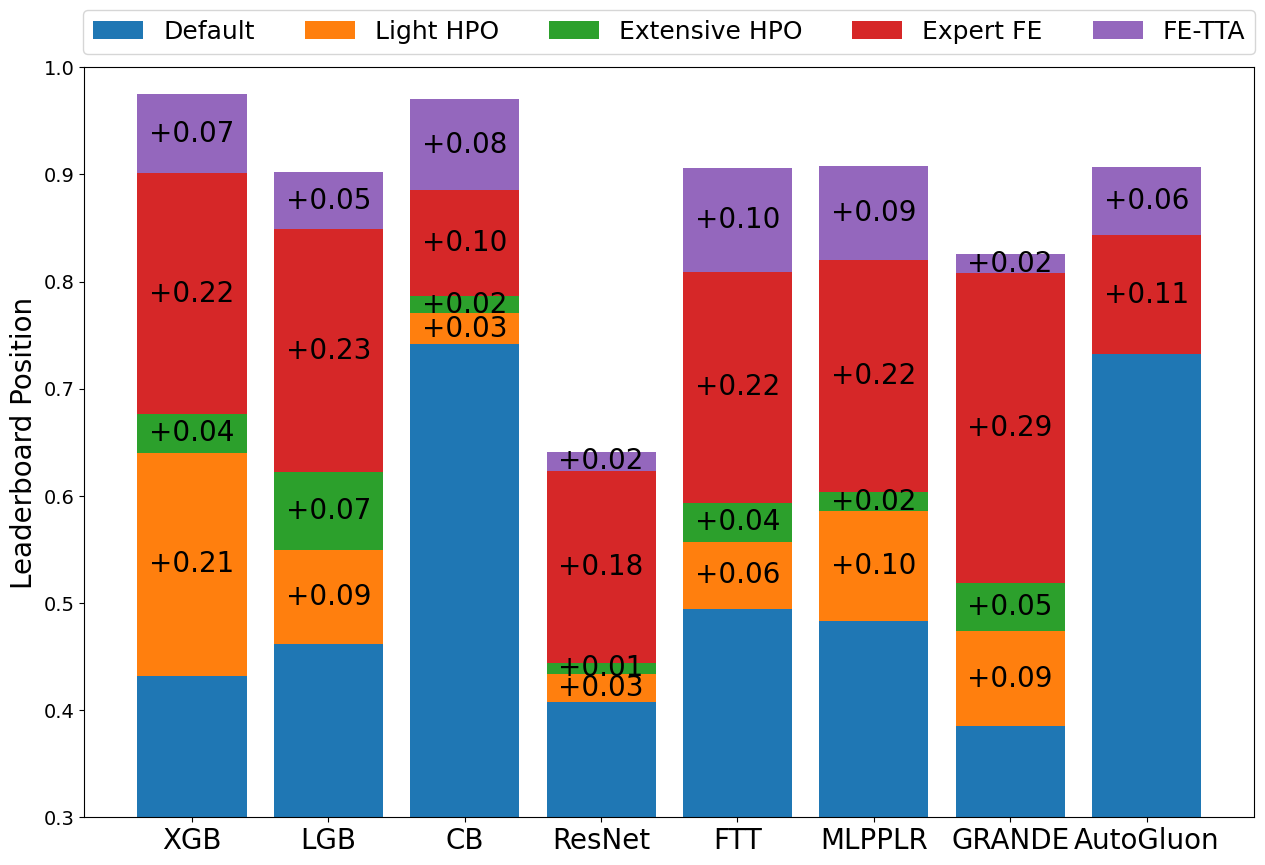

In [15]:
# Set up the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(13, 10))

# Set font sizes for LaTeX readability
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)

# Data preparation

def_ = pd.concat([df_min_def, df_min_auto], axis=1).fillna(0)
light = pd.concat([df_min_light, df_min_auto], axis=1).fillna(0)
ext = pd.concat([df_min_extensive, df_min_auto], axis=1).fillna(0)
fe = pd.concat([df_fe_extensive, df_fe_auto], axis=1).fillna(0)
tta = pd.concat([df_tta_extensive, df_tta_auto], axis=1).fillna(0)


data = {
    'Default': def_.mean(axis=0),
    'Light HPO': light.mean(axis=0),
    'Extensive HPO': ext.mean(axis=0),
    'Expert FE': fe.mean(axis=0),
    'FE-TTA': tta.mean(axis=0),
}

labels = list(data.keys())
bottom = np.zeros(len(data[labels[0]]))

# Create the bar plots
for label in labels:
    axes.bar(np.arange(len(data[label])), data[label] - bottom, bottom=bottom, label=label)
    for i in range(len(data[label])):
        gain = data[label][i] - bottom[i]
        if round(gain,2)>0.009 and label!="Default":
            axes.text(i, bottom[i] + gain / 2, f'+{gain:.2f}', ha='center', va='center', color='black',fontsize=20)
    bottom += data[label] - bottom

axes.set_ylabel('Leaderboard Position',fontsize=20)

axes.set_xticks(np.arange(len(data[labels[0]])))
axes.set_xticklabels([model_map[mod] for mod in list(df_min_def.columns) + ["AutoGluon"]],fontsize=20)

axes.set_ylim(0.3, 1.0)  # Adjust the y-axis limit to fit the data

# Create a single legend at the top of the figure
handles, labels = axes.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.02),fontsize=18)

# Adjust layout manually to prevent overlapping
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.2, wspace=0.1, hspace=0.1)

# Save the plot as a PDF file
plt.savefig('figures/mean_model_gain.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

plt.show()

In [16]:
all_cat_results = {}

exp_name = "neurips24_notest_tuned_old"
exp_name_use = "neurips24_notest_tuned"
dataset_name = "porto-seguro-safe-driver-prediction"
preprocess_type = "expert"
model_name = "CatBoost"

all_cat_results[dataset_name] = {}

for model_name in ["XGBoost", "LightGBM", "CatBoost"]:
    with open(f'./results/{dataset_name}/{preprocess_type}/{model_name}/{exp_name}/{exp_name_use}_seed{seed}.pickle', 'rb') as handle:
        exp_results = pickle.load(handle)
    
    cat_special = results[dataset_name][preprocess_type]['use_test_False'][model_name]["hpo"]['performance']["Test"]['private_percentile']
    cat_default = exp_results["performance"]["Test"]['private_percentile']
    
    all_cat_results[dataset_name][model_name] = {"Default": 1-cat_default, "OHE": 1-cat_special}

exp_name = "neurips24_notest_tuned_old"
exp_name_use = "neurips24_notest_tuned"
dataset_name = "bnp-paribas-cardif-claims-management"
preprocess_type = "expert"
model_name = "CatBoost"

all_cat_results[dataset_name] = {}

for model_name in ["XGBoost", "LightGBM", "CatBoost"]:
    cat_special = results[dataset_name][preprocess_type]['use_test_False'][model_name]["hpo"]['performance']["Test"]['private_percentile']
    if model_name=="CatBoost":
        cat_default = cat_special
    else:
        with open(f'./results/{dataset_name}/{preprocess_type}/{model_name}/{exp_name}/{exp_name_use}_seed{seed}.pickle', 'rb') as handle:
            exp_results = pickle.load(handle)
        
        cat_default = exp_results["performance"]["Test"]['private_percentile']
    
    all_cat_results[dataset_name][model_name] = {"Default": 1-cat_default, "Target": 1-cat_special}

pd.DataFrame(all_cat_results[dataset_name])

cat_df = pd.concat({dataset_map[dataset_name]: pd.DataFrame(all_cat_results[dataset_name]) for dataset_name in ["porto-seguro-safe-driver-prediction", "bnp-paribas-cardif-claims-management"]}).round(3)
cat_df

XGBoost  LightGBM  CatBoost
PSSDP Default    0.688     0.538     0.713
      OHE        0.994     0.944     0.973
BPCCM Default    0.402     0.350     0.996
      Target     0.992     0.992     0.996

In [17]:
print(cat_df[["XGBoost", "LightGBM", "CatBoost"]].transpose().round(2).astype(str).to_latex())

\begin{tabular}{lllll}
\toprule
 & \multicolumn{2}{r}{PSSDP} & \multicolumn{2}{r}{BPCCM} \\
 & Default & OHE & Default & Target \\
\midrule
XGBoost & 0.69 & 0.99 & 0.4 & 0.99 \\
LightGBM & 0.54 & 0.94 & 0.35 & 0.99 \\
CatBoost & 0.71 & 0.97 & 1.0 & 1.0 \\
\bottomrule
\end{tabular}



### Subsection 4.4: Isolated look at test-time adaptation

In [18]:
min_all = pd.concat([df_min_extensive,df_min_auto],axis=1).loc[['amazon-employee-access-challenge',
                                                         'otto-group-product-classification-challenge',
                                                         'santander-customer-satisfaction',
                                                         'santander-customer-transaction-prediction',
                                                         'ieee-fraud-detection',
                                                         'porto-seguro-safe-driver-prediction']]

fe_all = pd.concat([df_fe_extensive,df_fe_auto],axis=1).loc[['amazon-employee-access-challenge',
                                                         'otto-group-product-classification-challenge',
                                                         'santander-customer-satisfaction',
                                                         'santander-customer-transaction-prediction',
                                                         'ieee-fraud-detection',
                                                         'porto-seguro-safe-driver-prediction']]
tta_all = pd.concat([df_tta_extensive,df_tta_auto],axis=1).loc[['amazon-employee-access-challenge',
 'otto-group-product-classification-challenge',
 'santander-customer-satisfaction',
 'santander-customer-transaction-prediction',
 'ieee-fraud-detection',
 'porto-seguro-safe-driver-prediction']]

best_single = pd.DataFrame([min_all.drop("AutoGluon",axis=1).max(axis=1),fe_all.drop("AutoGluon",axis=1).max(axis=1),tta_all.drop("AutoGluon",axis=1).max(axis=1)]).transpose().round(3)
best_single.columns = ["Standardized", "Expert FE", "FE-TTA"]

auto = pd.DataFrame([min_all["AutoGluon"],fe_all["AutoGluon"],tta_all["AutoGluon"]]).transpose().round(3)
auto.columns = ["Standardized", "Expert FE", "FE-TTA"]

all = pd.concat({"Best single model": best_single, "AutoGluon": auto},axis=1)
all.index = [dataset_map[i] for i in all.index]
all


Best single model                     AutoGluon                 
           Standardized Expert FE FE-TTA Standardized Expert FE FE-TTA
AEAC              0.953     0.937  0.991        0.618     0.953  0.993
OGPCC             0.896     0.871  0.923        0.996     0.983  0.995
SCS               0.945     0.953  0.975        0.920     0.999  1.000
SCTP              0.518     0.962  0.992        0.498     0.531  0.991
IFD               0.662     0.988  0.992        0.205     0.351  0.432
PSSDP             0.656     0.994  0.995        0.562     0.707  0.742

In [19]:
print(all.astype(str).to_latex())

\begin{tabular}{lllllll}
\toprule
 & \multicolumn{3}{r}{Best single model} & \multicolumn{3}{r}{AutoGluon} \\
 & Standardized & Expert FE & FE-TTA & Standardized & Expert FE & FE-TTA \\
\midrule
AEAC & 0.953 & 0.937 & 0.991 & 0.618 & 0.953 & 0.993 \\
OGPCC & 0.896 & 0.871 & 0.923 & 0.996 & 0.983 & 0.995 \\
SCS & 0.945 & 0.953 & 0.975 & 0.92 & 0.999 & 1.0 \\
SCTP & 0.518 & 0.962 & 0.992 & 0.498 & 0.531 & 0.991 \\
IFD & 0.662 & 0.988 & 0.992 & 0.205 & 0.351 & 0.432 \\
PSSDP & 0.656 & 0.994 & 0.995 & 0.562 & 0.707 & 0.742 \\
\bottomrule
\end{tabular}



# Appendix C: Detailed Results

In [20]:
df_min_def.style.highlight_max(axis=1)

,XGBoost,LightGBM,CatBoost,ResNet,FTTransformer,MLP-PLR,GRANDE
mercedes-benz-greener-manufacturing,0.169718,0.225941,0.997385,0.230910,0.267259,0.605126,0.143305
santander-value-prediction-challenge,0.799328,0.928779,0.888690,0.797536,0.797760,0.920045,0.795073
amazon-employee-access-challenge,0.553318,0.613152,0.909953,0.502962,0.544431,0.527251,0.430095
otto-group-product-classification-challenge,0.818752,0.803078,0.795383,0.706184,0.728698,0.776290,0.689655
santander-customer-satisfaction,0.465794,0.439406,0.469116,0.368061,0.600078,0.411845,0.370407
bnp-paribas-cardif-claims-management,0.256331,0.280287,0.952772,0.260780,0.281314,0.309719,0.069815
santander-customer-transaction-prediction,0.337751,0.363574,0.430873,0.287249,0.373515,0.314785,0.375686
homesite-quote-conversion,0.319294,0.343199,0.936255,0.377917,0.469550,0.418327,0.454752
ieee-fraud-detection,0.310936,0.323525,0.518647,0.225649,0.407553,0.293627,0.177183
porto-seguro-safe-driver-prediction,0.288152,0.300950,0.519100,0.314718,0.477603,0.258096,0.347489


In [21]:
df_min_all = pd.concat({"Default": df_min_def, "Light": df_min_light,"Extensive": df_min_extensive})
df_min_all_latex = df_min_all.copy().round(3).astype(str)
df_min_all_latex[(df_min_all.transpose()>df_min_all.max(axis=1)-0.01).transpose()] = "\\textbf{" + df_min_all_latex[(df_min_all.transpose()>df_min_all.max(axis=1)-0.01).transpose()] + "}"
print(df_min_all_latex.to_latex())

\begin{tabular}{lllllllll}
\toprule
 &  & XGBoost & LightGBM & CatBoost & ResNet & FTTransformer & MLP-PLR & GRANDE \\
\midrule
\multirow[t]{10}{*}{Default} & mercedes-benz-greener-manufacturing & 0.17 & 0.226 & \textbf{0.997} & 0.231 & 0.267 & 0.605 & 0.143 \\
 & santander-value-prediction-challenge & 0.799 & \textbf{0.929} & 0.889 & 0.798 & 0.798 & \textbf{0.92} & 0.795 \\
 & amazon-employee-access-challenge & 0.553 & 0.613 & \textbf{0.91} & 0.503 & 0.544 & 0.527 & 0.43 \\
 & otto-group-product-classification-challenge & \textbf{0.819} & 0.803 & 0.795 & 0.706 & 0.729 & 0.776 & 0.69 \\
 & santander-customer-satisfaction & 0.466 & 0.439 & 0.469 & 0.368 & \textbf{0.6} & 0.412 & 0.37 \\
 & bnp-paribas-cardif-claims-management & 0.256 & 0.28 & \textbf{0.953} & 0.261 & 0.281 & 0.31 & 0.07 \\
 & santander-customer-transaction-prediction & 0.338 & 0.364 & \textbf{0.431} & 0.287 & 0.374 & 0.315 & 0.376 \\
 & homesite-quote-conversion & 0.319 & 0.343 & \textbf{0.936} & 0.378 & 0.47 & 0.418 & 0

In [22]:
df_fe_all = pd.concat({"Default": df_fe_def, "Light": df_fe_light,"Extensive": df_fe_extensive})
df_fe_all_latex = df_fe_all.copy().round(3).astype(str)
df_fe_all_latex[(df_fe_all.transpose()>df_fe_all.max(axis=1)-0.01).transpose()] = "\\textbf{" + df_fe_all_latex[(df_fe_all.transpose()>df_fe_all.max(axis=1)-0.01).transpose()] + "}"
print(df_fe_all_latex.to_latex())

\begin{tabular}{lllllllll}
\toprule
 &  & XGBoost & LightGBM & CatBoost & ResNet & FTTransformer & MLP-PLR & GRANDE \\
\midrule
\multirow[t]{10}{*}{Default} & mercedes-benz-greener-manufacturing & 0.706 & 0.545 & \textbf{0.999} & 0.626 & 0.641 & 0.964 & 0.61 \\
 & santander-value-prediction-challenge & \textbf{0.993} & \textbf{0.987} & \textbf{0.987} & 0.941 & 0.968 & \textbf{0.989} & 0.946 \\
 & amazon-employee-access-challenge & 0.736 & 0.84 & \textbf{0.937} & 0.695 & 0.914 & 0.407 & 0.407 \\
 & otto-group-product-classification-challenge & \textbf{0.806} & 0.792 & \textbf{0.797} & 0.702 & 0.718 & 0.731 & 0.681 \\
 & santander-customer-satisfaction & 0.59 & 0.758 & 0.673 & 0.366 & \textbf{0.879} & 0.466 & 0.393 \\
 & bnp-paribas-cardif-claims-management & \textbf{0.994} & \textbf{0.995} & \textbf{0.994} & \textbf{0.987} & \textbf{0.993} & \textbf{0.995} & \textbf{0.991} \\
 & santander-customer-transaction-prediction & 0.311 & 0.373 & \textbf{0.417} & 0.284 & 0.376 & 0.345 & 0.395 \\

In [23]:
df_tta_all = pd.concat({"Default": df_tta_def, "Light": df_tta_light,"Extensive": df_tta_extensive})
df_tta_all_latex = df_tta_all.copy().round(3).astype(str)
df_tta_all_latex[(df_tta_all.transpose()>df_tta_all.max(axis=1)-0.01).transpose()] = "\\textbf{" + df_tta_all_latex[(df_tta_all.transpose()>df_tta_all.max(axis=1)-0.01).transpose()] + "}"
print(df_tta_all_latex.to_latex())

\begin{tabular}{lllllllll}
\toprule
 &  & XGBoost & LightGBM & CatBoost & ResNet & FTTransformer & MLP-PLR & GRANDE \\
\midrule
\multirow[t]{10}{*}{Default} & mercedes-benz-greener-manufacturing & 0.706 & 0.545 & \textbf{0.999} & 0.626 & 0.641 & 0.964 & 0.61 \\
 & santander-value-prediction-challenge & \textbf{0.993} & \textbf{0.987} & \textbf{0.987} & 0.941 & 0.968 & \textbf{0.989} & 0.946 \\
 & amazon-employee-access-challenge & 0.944 & 0.948 & \textbf{0.98} & 0.725 & 0.758 & 0.46 & 0.445 \\
 & otto-group-product-classification-challenge & \textbf{0.856} & \textbf{0.847} & 0.84 & 0.714 & 0.714 & 0.783 & 0.718 \\
 & santander-customer-satisfaction & 0.543 & 0.611 & 0.701 & 0.39 & \textbf{0.892} & 0.635 & 0.431 \\
 & bnp-paribas-cardif-claims-management & \textbf{0.994} & \textbf{0.995} & \textbf{0.994} & \textbf{0.987} & \textbf{0.993} & \textbf{0.995} & \textbf{0.991} \\
 & santander-customer-transaction-prediction & \textbf{0.985} & \textbf{0.987} & \textbf{0.988} & 0.302 & \textbf{

In [24]:
df_auto_all = pd.concat({"Default": df_min_auto["AutoGluon"], "Expert FE": df_fe_auto["AutoGluon"],"FE-TTA": df_tta_auto["AutoGluon"]},axis=1)
print(df_auto_all.transpose().round(3).astype(str).to_latex())

\begin{tabular}{lllllllllll}
\toprule
 & mercedes-benz-greener-manufacturing & santander-value-prediction-challenge & amazon-employee-access-challenge & otto-group-product-classification-challenge & santander-customer-satisfaction & bnp-paribas-cardif-claims-management & santander-customer-transaction-prediction & homesite-quote-conversion & ieee-fraud-detection & porto-seguro-safe-driver-prediction \\
\midrule
Default & 0.74 & 0.799 & 0.618 & 0.996 & 0.92 & 0.991 & 0.498 & 0.992 & 0.205 & 0.562 \\
Expert FE & 0.964 & 0.963 & 0.953 & 0.983 & 0.999 & 0.995 & 0.531 & 0.992 & 0.351 & 0.707 \\
FE-TTA & 0.964 & 0.963 & 0.993 & 0.995 & 1.0 & 0.995 & 0.991 & 0.992 & 0.432 & 0.742 \\
\bottomrule
\end{tabular}



## Appendix D: Additional Results

In [25]:
df_min_def.index = df_min_def.index.map(dataset_map)
df_fe_def.index = df_fe_def.index.map(dataset_map)
df_tta_def.index = df_tta_def.index.map(dataset_map)
df_min_light.index = df_min_light.index.map(dataset_map)
df_fe_light.index = df_fe_light.index.map(dataset_map)
df_tta_light.index = df_tta_light.index.map(dataset_map)
df_min_extensive.index = df_min_extensive.index.map(dataset_map)
df_fe_extensive.index = df_fe_extensive.index.map(dataset_map)
df_tta_extensive.index = df_tta_extensive.index.map(dataset_map)
df_min_auto.index = df_min_auto.index.map(dataset_map)
df_fe_auto.index = df_fe_auto.index.map(dataset_map)
df_tta_auto.index = df_tta_auto.index.map(dataset_map)

### D.1: Comparison of Preprocessing Pipelines per Model and Dataset

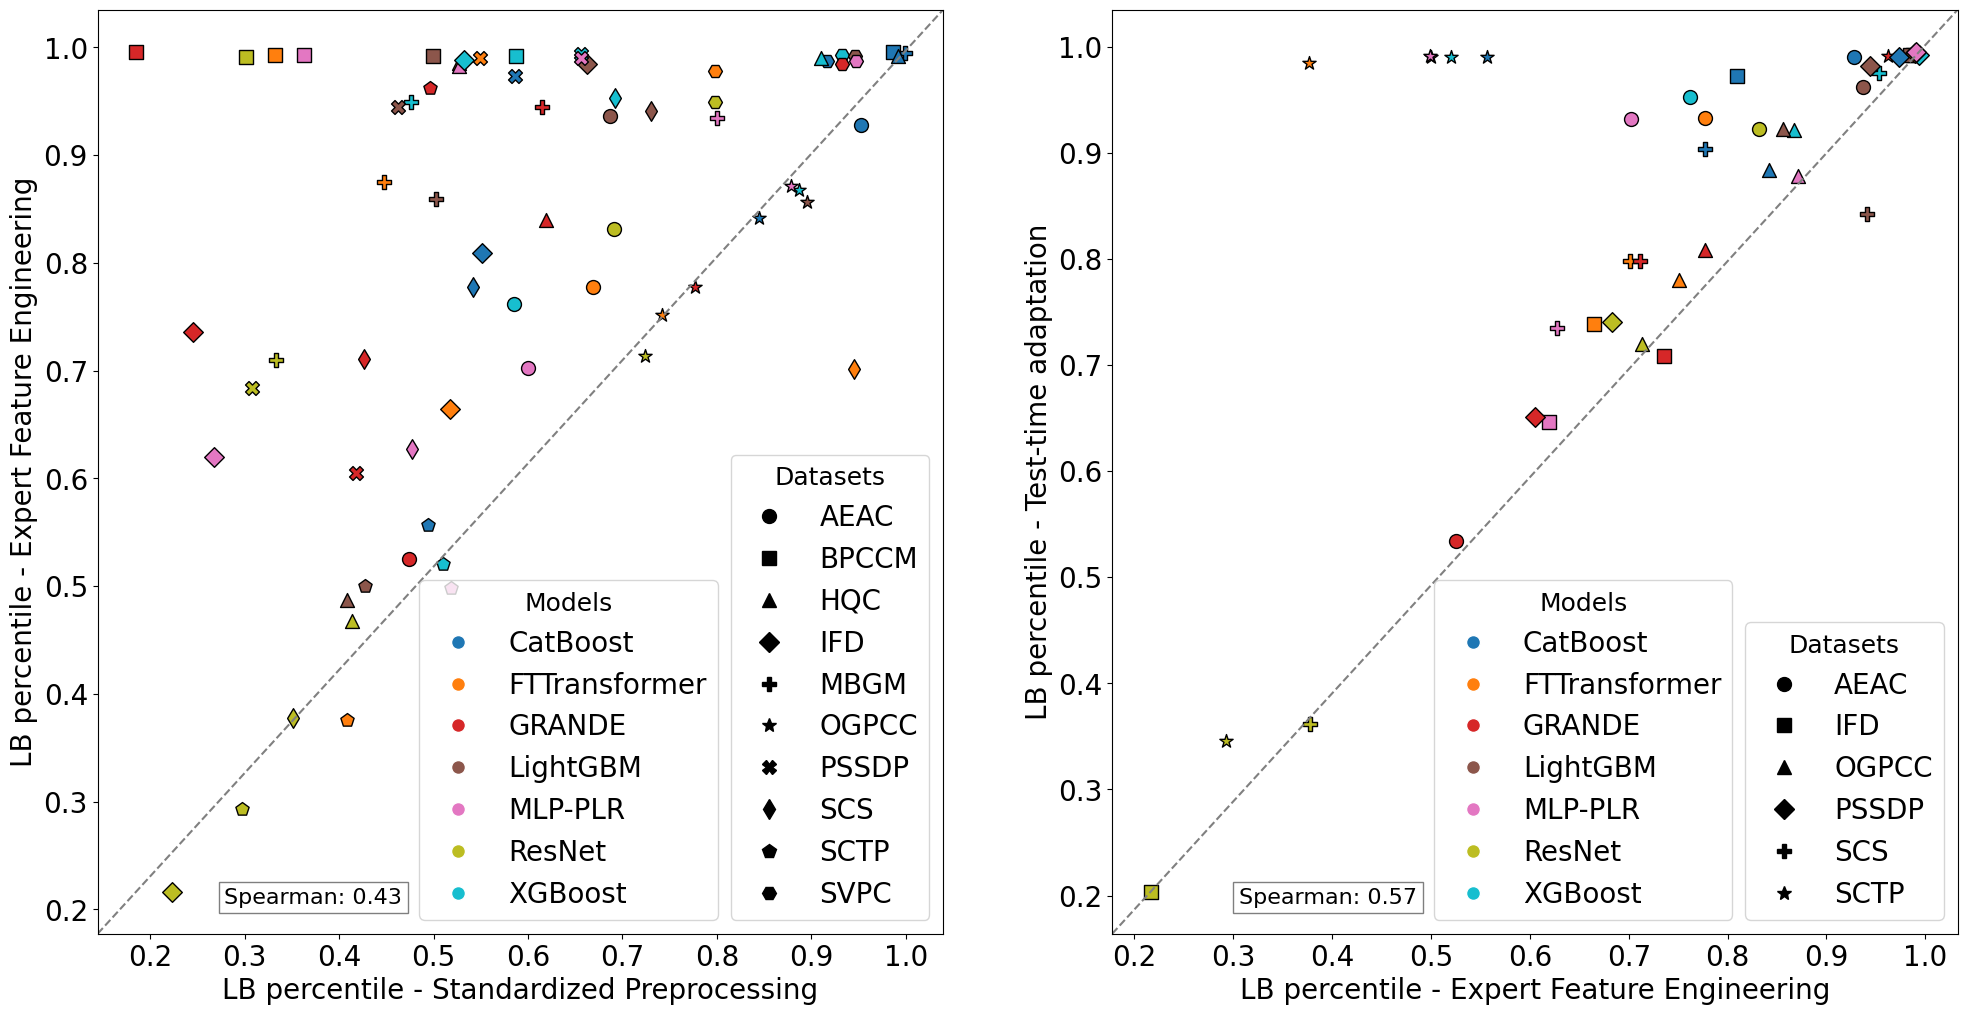

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from matplotlib.lines import Line2D
from scipy.stats import spearmanr

# Assuming df_fe_extensive, df_tta_extensive, and df_c are defined dataframes
df_a = df_min_extensive
df_b = df_fe_extensive
df_c = df_tta_extensive  # Replace with the actual variable name for df_c

# Label encoding for columns
label_encoder_columns = LabelEncoder()
column_labels_a_b = label_encoder_columns.fit_transform(np.tile(df_a.fillna(0.5).columns, 10))
column_labels_b_c = label_encoder_columns.fit_transform(np.tile(df_b.fillna(0.5).columns, 10))

# Label encoding for indices
label_encoder_indices = LabelEncoder()
index_labels_a_b = label_encoder_indices.fit_transform(np.repeat(df_a.fillna(0.5).index, 7))
index_labels_b_c = label_encoder_indices.fit_transform(np.repeat(df_b.fillna(0.5).index, 7))

# Markers for the indices
markers = ['o', 's', '^', 'D', 'P', '*', 'X', 'd', 'p', 'H']

# Define color palette
colors = plt.cm.tab10(np.linspace(0, 1, len(df_a.fillna(0.5).columns)))

# Create the figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(24, 12))

# First subplot: df_a vs df_b
for i, (col_label, idx_label) in enumerate(zip(column_labels_a_b, index_labels_a_b)):
    axs[0].scatter(df_a.fillna(0.5).values.ravel()[i], df_b.fillna(0.5).values.ravel()[i], 
                   color=colors[col_label], 
                   marker=markers[idx_label % len(markers)], edgecolor='black', s=100)

# Custom legend handles for columns (colors)
handles_columns = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10) 
                   for i in range(len(df_a.fillna(0.5).columns))]
legend_columns = axs[0].legend(handles_columns, label_encoder_columns.classes_, title="Models", loc='lower right', bbox_to_anchor=(0.75, 0.0), title_fontsize=18)

# Custom legend handles for indices (shapes)
handles_indices = [Line2D([0], [0], marker=markers[i % len(markers)], color='black', markersize=10, linestyle='None') 
                   for i in range(len(df_a.fillna(0.5).index))]
legend_indices = axs[0].legend(handles_indices, [dat for dat in label_encoder_indices.classes_], title="Datasets", loc='lower right', bbox_to_anchor=(1.0, 0.0), title_fontsize=18)

# Add the legends to the plot
axs[0].add_artist(legend_columns)

# Add labels and title for the first subplot
axs[0].set_xlabel('LB percentile - Standardized Preprocessing')
axs[0].set_ylabel('LB percentile - Expert Feature Engineering')
# axs[0].set_title('Dataset A vs B')

# Add a line from lower left to upper right for the first subplot
axs[0].plot([0, 1], [0, 1], transform=axs[0].transAxes, color='gray', linestyle='--')

# Calculate Spearman correlation for df_a vs df_b
spearman_ab, _ = spearmanr(df_a.fillna(0.5).values.ravel(), df_b.fillna(0.5).values.ravel())
axs[0].text(0.15, 0.05, f'Spearman: {spearman_ab:.2f}', transform=axs[0].transAxes, 
            verticalalignment='top', fontsize=16, bbox=dict(facecolor='white', alpha=0.5))


df_b = df_fe_extensive.loc[['AEAC', 'OGPCC', 'SCS', 'SCTP', 'IFD', 'PSSDP']]
df_c = df_tta_extensive.loc[['AEAC', 'OGPCC', 'SCS', 'SCTP', 'IFD', 'PSSDP']]  # Replace with the actual variable name for df_c

# Label encoding for columns
label_encoder_columns = LabelEncoder()
column_labels_a_b = label_encoder_columns.fit_transform(np.tile(df_a.fillna(0.5).columns, 10))
column_labels_b_c = label_encoder_columns.fit_transform(np.tile(df_b.fillna(0.5).columns, 10))

# Label encoding for indices
label_encoder_indices = LabelEncoder()
index_labels_a_b = label_encoder_indices.fit_transform(np.repeat(df_a.fillna(0.5).index, 7))
index_labels_b_c = label_encoder_indices.fit_transform(np.repeat(df_b.fillna(0.5).index, 7))

# Second subplot: df_b vs df_c
for i, (col_label, idx_label) in enumerate(zip(column_labels_b_c, index_labels_b_c)):
    axs[1].scatter(df_b.fillna(0.5).values.ravel()[i], df_c.fillna(0.5).values.ravel()[i], 
                   color=colors[col_label], 
                   marker=markers[idx_label % len(markers)], edgecolor='black', s=100)

# Custom legend handles for columns (colors)
handles_columns = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10) 
                   for i in range(len(df_b.fillna(0.5).columns))]
legend_columns = axs[1].legend(handles_columns, label_encoder_columns.classes_, title="Models", loc='lower right', bbox_to_anchor=(0.75, 0.0), title_fontsize=18)

# Custom legend handles for indices (shapes)
handles_indices = [Line2D([0], [0], marker=markers[i % len(markers)], color='black', markersize=10, linestyle='None') 
                   for i in range(len(df_b.fillna(0.5).index))]
legend_indices = axs[1].legend(handles_indices, [dat for dat in label_encoder_indices.classes_], title="Datasets", loc='lower right', bbox_to_anchor=(1.0, 0.0), title_fontsize=18)

# Add the legends to the plot
axs[1].add_artist(legend_columns)

# Add labels and title for the second subplot
axs[1].set_xlabel('LB percentile - Expert Feature Engineering')
axs[1].set_ylabel('LB percentile - Test-time adaptation')
# axs[1].set_title('Dataset B vs C')

# Add a line from lower left to upper right for the second subplot
axs[1].plot([0, 1], [0, 1], transform=axs[1].transAxes, color='gray', linestyle='--')

# Calculate Spearman correlation for df_b vs df_c
spearman_bc, _ = spearmanr(df_b.fillna(0.5).values.ravel(), df_c.fillna(0.5).values.ravel())
axs[1].text(0.15, 0.05, f'Spearman: {spearman_bc:.2f}', transform=axs[1].transAxes, 
            verticalalignment='top', fontsize=16, bbox=dict(facecolor='white', alpha=0.5))


# Save the plot as a PDF file
plt.savefig('figures/pipeline_scatterplots.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

# Display plot
plt.show()

### Appendix D.2

In [27]:
eval_against_cb = False

subdfs = []
for num, df_use in enumerate([df_min_def,df_min_light,df_min_extensive,
          df_fe_def,df_fe_light,df_fe_extensive,
      df_tta_def,df_tta_light,df_tta_extensive]):
    df_temp = pd.DataFrame(list(product(df_use.index,df_use.columns)),columns=["dataset", "model"])
    if eval_against_cb:
        df_temp["target"] = (df_use.transpose()-df_min_def["CatBoost"]).transpose().clip(-np.inf,0).values.ravel()
    else:
        df_temp["target"] = df_use.values.ravel()

    if num<=2:
        prep = 0
        adapt = 0
    elif num<=5:
        prep = 1
        adapt = 0
    else:
        prep = 1
        adapt = 1
        df_temp = df_temp.loc[[i in ['AEAC', 'OGPCC', 'SCS', 'SCTP', 'IFD', 'PSSDP'] for i in df_temp.dataset]]
        

    if num in [0,3,6]:
        default = 1
    else:
        default = 0
    
    if num in [1,4,7]:
        light = 1
    else:
        light = 0
    
    if num in [2,5,8]:
        extensive = 1
    else:
        extensive = 0
    
    df_temp["default"] = default
    df_temp["light"] = light
    df_temp["extensive"] = extensive
    df_temp["Feature Engineering"] = prep
    df_temp["Test Time Adaptation"] = adapt
    # df_temp["Model Selection"] = df_temp.apply(lambda i: np.logical_and(i.target==df_temp.loc[df_temp.dataset==i.dataset,"target"].max(), i.model!="CatBoost"),axis=1)*1
    max_without_cb = dict(df_temp.loc[df_temp.model!="CatBoost"].groupby("dataset").max()["target"])
    df_temp["Model Selection"] = df_temp.apply(lambda i: np.logical_and(i.target==max_without_cb[i.dataset],i.model!="CatBoost"), axis=1)*1

    subdfs.append(df_temp)
Xy = pd.concat(subdfs)
Xy.loc[Xy.model=="CatBoost", "Model Selection"] = -1
Xy

,dataset,model,target,default,light,extensive,Feature Engineering,Test Time Adaptation,Model Selection
0,MBGM,XGBoost,0.169718,1,0,0,0,0,0
1,MBGM,LightGBM,0.225941,1,0,0,0,0,0
2,MBGM,CatBoost,0.997385,1,0,0,0,0,-1
3,MBGM,ResNet,0.230910,1,0,0,0,0,0
4,MBGM,FTTransformer,0.267259,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
65,PSSDP,CatBoost,0.989917,0,0,1,1,1,-1
66,PSSDP,ResNet,0.740935,0,0,1,1,1,0
67,PSSDP,FTTransformer,0.993601,0,0,1,1,1,0
68,PSSDP,MLP-PLR,0.995152,0,0,1,1,1,1


#### Distributions of leaderboard scores

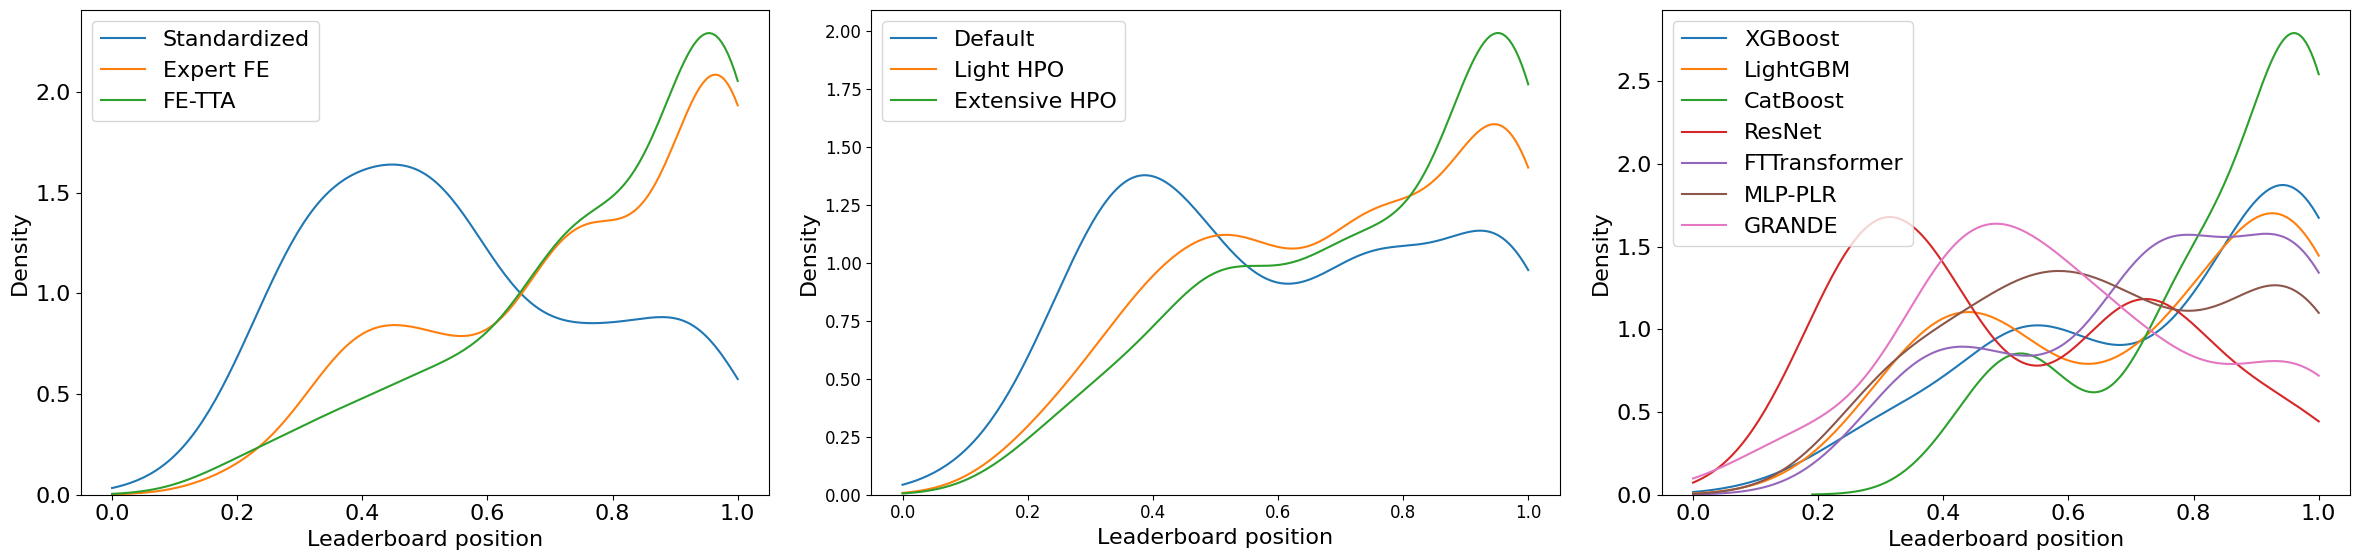

In [28]:
import seaborn as sns

# Set up the figure and axes
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# First subplot
sns.kdeplot(Xy.loc[np.logical_and(Xy["Feature Engineering"] == 0, Xy["Test Time Adaptation"] == 0), "target"], shade=False, clip=(0, 1), ax=axes[0])
sns.kdeplot(Xy.loc[np.logical_and(Xy["Feature Engineering"] == 1, Xy["Test Time Adaptation"] == 0), "target"], shade=False, clip=(0, 1), ax=axes[0])
sns.kdeplot(Xy.loc[np.logical_and(Xy["Feature Engineering"] == 1, Xy["Test Time Adaptation"] == 1), "target"], shade=False, clip=(0, 1), ax=axes[0])

# axes[0].set_title('Kernel Density Estimation of Target', fontsize=18)
axes[0].set_xlabel('Leaderboard position', fontsize=16)
axes[0].set_ylabel('Density', fontsize=16)
axes[0].legend(["Standardized", "Expert FE", "FE-TTA"], fontsize=16, loc='upper left')
axes[0].tick_params(axis='both', which='major', labelsize=16)

# Second subplot
sns.kdeplot(Xy.loc[Xy["default"] == 1, "target"], shade=False, clip=(0, 1), ax=axes[1])
sns.kdeplot(Xy.loc[Xy["light"] == 1, "target"], shade=False, clip=(0, 1), ax=axes[1])
sns.kdeplot(Xy.loc[Xy["extensive"] == 1, "target"], shade=False, clip=(0, 1), ax=axes[1])

# axes[1].set_title('Kernel Density Estimation of Target', fontsize=18)
axes[1].set_xlabel('Leaderboard position', fontsize=16)
axes[1].set_ylabel('Density', fontsize=16)
axes[1].legend(["Default", "Light HPO", "Extensive HPO"], fontsize=16, loc='upper left')
axes[1].tick_params(axis='both', which='major', labelsize=12)

# Third subplot
sns.kdeplot(Xy.loc[Xy["model"] == model_names[0], "target"], shade=False, clip=(0, 1), ax=axes[2])
sns.kdeplot(Xy.loc[Xy["model"] == model_names[1], "target"], shade=False, clip=(0, 1), ax=axes[2])
sns.kdeplot(Xy.loc[Xy["model"] == model_names[2], "target"], shade=False, clip=(0, 1), ax=axes[2])
sns.kdeplot(Xy.loc[Xy["model"] == model_names[3], "target"], shade=False, clip=(0, 1), ax=axes[2])
sns.kdeplot(Xy.loc[Xy["model"] == model_names[4], "target"], shade=False, clip=(0, 1), ax=axes[2])
sns.kdeplot(Xy.loc[Xy["model"] == model_names[5], "target"], shade=False, clip=(0, 1), ax=axes[2])
sns.kdeplot(Xy.loc[Xy["model"] == model_names[6], "target"], shade=False, clip=(0, 1), ax=axes[2])

# axes[2].set_title('Kernel Density Estimation of Target', fontsize=18)
axes[2].set_xlabel('Leaderboard position', fontsize=16)
axes[2].set_ylabel('Density', fontsize=16)
axes[2].legend(model_names, fontsize=16, loc='upper left')
axes[2].tick_params(axis='both', which='major', labelsize=16)

# Adjust layout for better spacing
plt.tight_layout()

plt.savefig('figures/kde_plots.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

# Show the combined plot
plt.show()

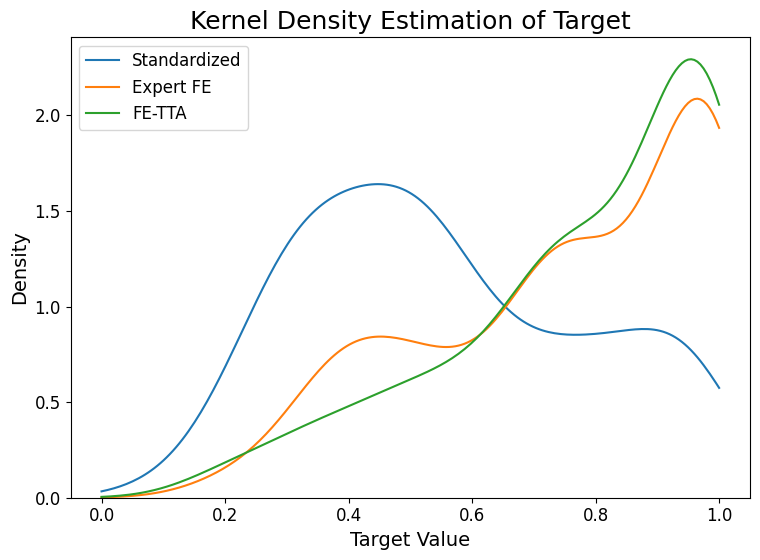

In [29]:
import seaborn as sns
# Create the KDE plot
plt.figure(figsize=(8, 6))

# Plot KDEs
sns.kdeplot(Xy.loc[np.logical_and(Xy["Feature Engineering"] == 0, Xy["Test Time Adaptation"] == 0), "target"], shade=False,clip=(0,1))
sns.kdeplot(Xy.loc[np.logical_and(Xy["Feature Engineering"] == 1, Xy["Test Time Adaptation"] == 0), "target"], shade=False,clip=(0,1))
sns.kdeplot(Xy.loc[np.logical_and(Xy["Feature Engineering"] == 1, Xy["Test Time Adaptation"] == 1), "target"], shade=False,clip=(0,1))

# Add titles and labels with larger fonts
plt.title('Kernel Density Estimation of Target', fontsize=18)
plt.xlabel('Target Value', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Add legend with larger font and better alignment
plt.legend(["Standardized", "Expert FE", "FE-TTA"], fontsize=12, loc='upper left')

# Increase the size of tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

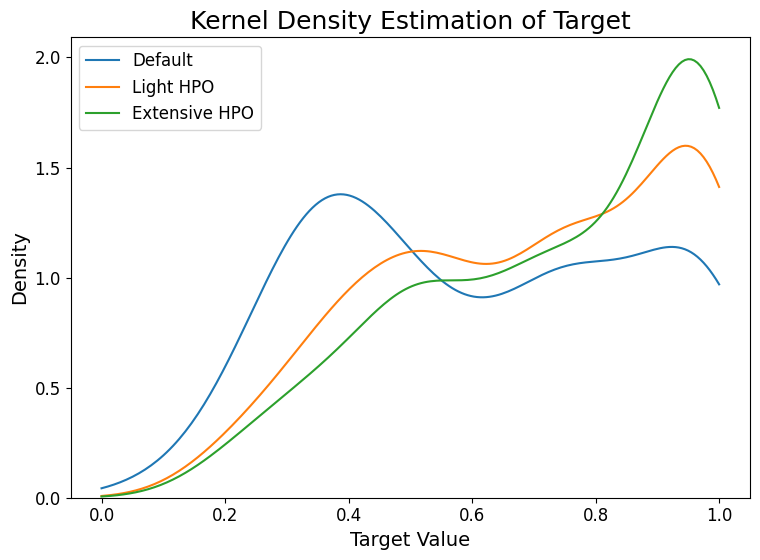

In [30]:
import seaborn as sns
# Create the KDE plot
plt.figure(figsize=(8, 6))

# Plot KDEs
sns.kdeplot(Xy.loc[Xy["default"] == 1, "target"], shade=False,clip=(0,1))
sns.kdeplot(Xy.loc[Xy["light"] == 1, "target"], shade=False,clip=(0,1))
sns.kdeplot(Xy.loc[Xy["extensive"] == 1, "target"], shade=False,clip=(0,1))

# Add titles and labels with larger fonts
plt.title('Kernel Density Estimation of Target', fontsize=18)
plt.xlabel('Target Value', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Add legend with larger font and better alignment
plt.legend(["Default", "Light HPO", "Extensive HPO"], fontsize=12, loc='upper left')

# Increase the size of tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

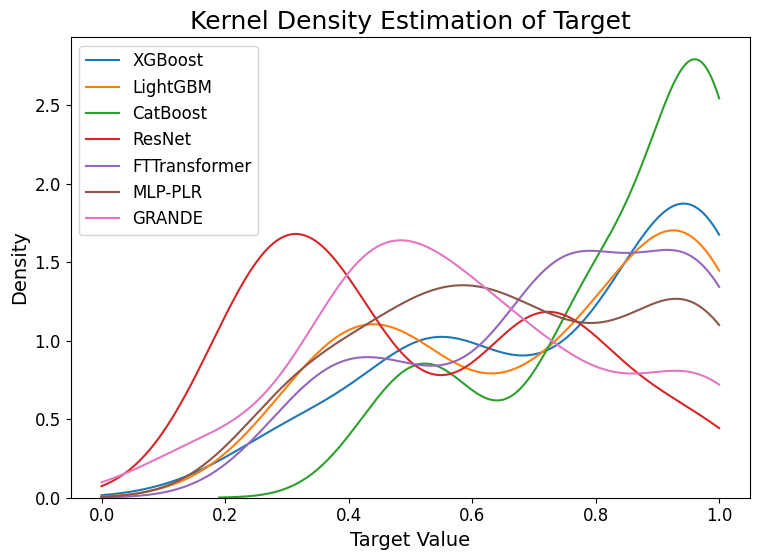

In [31]:
import seaborn as sns
# Create the KDE plot
plt.figure(figsize=(8, 6))

# Plot KDEs
sns.kdeplot(Xy.loc[Xy["model"] == model_names[0], "target"], shade=False,clip=(0,1))
sns.kdeplot(Xy.loc[Xy["model"] == model_names[1], "target"], shade=False,clip=(0,1))
sns.kdeplot(Xy.loc[Xy["model"] == model_names[2], "target"], shade=False,clip=(0,1))
sns.kdeplot(Xy.loc[Xy["model"] == model_names[3], "target"], shade=False,clip=(0,1))
sns.kdeplot(Xy.loc[Xy["model"] == model_names[4], "target"], shade=False,clip=(0,1))
sns.kdeplot(Xy.loc[Xy["model"] == model_names[5], "target"], shade=False,clip=(0,1))
sns.kdeplot(Xy.loc[Xy["model"] == model_names[6], "target"], shade=False,clip=(0,1))

# Add titles and labels with larger fonts
plt.title('Kernel Density Estimation of Target', fontsize=18)
plt.xlabel('Target Value', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Add legend with larger font and better alignment
plt.legend(model_names, fontsize=12, loc='upper left')

# Increase the size of tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

### Statistical Analysis

In [32]:
from sklearn.preprocessing import OneHotEncoder

# Xy = pd.DataFrame(df_parts)


### VERSION A: HPO means over all models
# Xy["Default"] = Xy["default"]
Xy["Light HPO"] = Xy["light"] #((Xy["model"]=="CatBoost")*1)*Xy["light"]
Xy["Extensive HPO"] = Xy["extensive"] #((Xy["model"]=="CatBoost")*1)*Xy["extensive"]
Xy.drop(["default", "light","extensive"],axis=1,inplace=True)

### VERSION B: Make light and extensive HPO only include CB
# Only keep default & light setting for CatBoost
# Xy = Xy.loc[~np.logical_and(Xy.default==1,Xy.model!="CatBoost")]
# Xy = Xy.loc[~np.logical_and(Xy.light==1,Xy.model!="CatBoost")]

# # Xy["Default"] = ((Xy["model"]=="CatBoost")*1)*Xy["default"]
# Xy["Light HPO"] = ((Xy["model"]=="CatBoost")*1)*Xy["light"]
# Xy["Extensive HPO"] = ((Xy["model"]=="CatBoost")*1)*Xy["extensive"]
# Xy.drop(["default", "light","extensive"],axis=1,inplace=True)

# Make model selection be on tuned hyperparameters only
# Xy["Model Selection (default)"] = (Xy["model"]!="CatBoost")*1
# Xy["Model Selection (light HPO)"] = Xy["Model Selection (default)"]*Xy["light"]
# Xy["CASH"] = Xy["Model Selection (default)"]*Xy["extensive"]

# Xy["Model Selection"] = (Xy.model!="CatBoost")*1
# Xy["Use_CatBoost"] = (Xy.model=="CatBoost")*1
Xy.drop(["model"],axis=1,inplace=True)

# ohe = OneHotEncoder()
# ohe.fit(Xy[["dataset"]])
# Xy[ohe.categories_[0]] = ohe.transform(Xy[["dataset"]]).toarray()
# Xy.drop(["dataset", Xy.dataset.iloc[0]],axis=1,inplace=True)
# Xy.drop(dataset_names[1:],axis=1,inplace=True)
# Xy.drop("dataset",axis=1,inplace=True)

# ohe = OneHotEncoder()
# ohe.fit(Xy[["model"]])
# Xy[ohe.categories_[0]] = ohe.transform(Xy[["model"]]).toarray()
# Xy.drop(["model","ResNet"],axis=1,inplace=True)

# Xy.drop(["dataset", "model", "light", "extensive"],axis=1,inplace=True)

y = Xy["target"]
X = Xy.drop(["target"],axis=1)

X = X[~y.isna()]
y = y[~y.isna()]
X

,dataset,Feature Engineering,Test Time Adaptation,Model Selection,Light HPO,Extensive HPO
0,MBGM,0,0,0,0,0
1,MBGM,0,0,0,0,0
2,MBGM,0,0,-1,0,0
3,MBGM,0,0,0,0,0
4,MBGM,0,0,0,0,0
...,...,...,...,...,...,...
65,PSSDP,1,1,-1,0,1
66,PSSDP,1,1,0,0,1
67,PSSDP,1,1,0,0,1
68,PSSDP,1,1,1,0,1


In [33]:
from statsmodels.regression.mixed_linear_model import MixedLM
from statsmodels.tools.tools import add_constant

# Assume X and y are already defined as your features and target variable

label_enc = LabelEncoder()
X.dataset = label_enc.fit_transform(X.dataset)
# X.model = label_enc.fit_transform(X.model)

# Fit the mixed linear model
# Add a constant term to the model
X_with_const = add_constant(X.drop(["dataset"],axis=1))

# Define the mixed model
model = MixedLM(y, X_with_const, groups=X["dataset"])

# Fit the model
result = model.fit()

# Get the p-values
p_values = result.pvalues

# Get the coefficients
coefficients = result.params

# Combine coefficients and p-values in a DataFrame
df_imp = pd.DataFrame({'Modeling Step': coefficients.index, 'β-Coeff': coefficients.round(3), 'p-value': p_values.round(3)})

# Filter out dataset names if needed
df_imp = df_imp.loc[df_imp["Modeling Step"].apply(lambda x: x not in dataset_names)]

# print(model.rsquared)

# Display the DataFrame
# import ace_tools as tools; tools.display_dataframe_to_user(name="Model Summary", dataframe=df_imp)
df_imp

,Modeling Step,β-Coeff,p-value
const,const,0.485,0.000
Feature Engineering,Feature Engineering,0.201,0.000
Test Time Adaptation,Test Time Adaptation,0.080,0.001
Model Selection,Model Selection,0.004,0.810
Light HPO,Light HPO,0.085,0.000
Extensive HPO,Extensive HPO,0.125,0.000
Group Var,Group Var,0.354,0.047


In [34]:
print(result.summary().as_latex())

\begin{table}
\caption{Mixed Linear Model Regression Results}
\label{}
\begin{center}
\begin{tabular}{llll}
\hline
Model:            & MixedLM & Dependent Variable: & target   \\
No. Observations: & 546     & Method:             & REML     \\
No. Groups:       & 10      & Scale:              & 0.0380   \\
Min. group size:  & 42      & Log-Likelihood:     & 88.5557  \\
Max. group size:  & 63      & Converged:          & Yes      \\
Mean group size:  & 54.6    &                     &          \\
\hline
\end{tabular}
\end{center}

\begin{center}
\begin{tabular}{lrrrrrr}
\hline
                     & Coef. & Std.Err. &      z & P$> |$z$|$ & [0.025 & 0.975]  \\
\hline
const                & 0.485 &    0.041 & 11.898 &       0.000 &  0.405 &  0.565  \\
Feature Engineering  & 0.201 &    0.019 & 10.561 &       0.000 &  0.164 &  0.238  \\
Test Time Adaptation & 0.080 &    0.023 &  3.437 &       0.001 &  0.034 &  0.126  \\
Model Selection      & 0.004 &    0.016 &  0.240 &       0.810 & -0.027 &

In [35]:
{label_enc.inverse_transform([i])[0]: result.random_effects[i] for i in result.random_effects}

{'AEAC': Group Var    0.024069
 dtype: float64,
 'BPCCM': Group Var    0.045967
 dtype: float64,
 'HQC': Group Var   -0.013565
 dtype: float64,
 'IFD': Group Var   -0.1141
 dtype: float64,
 'MBGM': Group Var    0.015354
 dtype: float64,
 'OGPCC': Group Var    0.068592
 dtype: float64,
 'PSSDP': Group Var   -0.066502
 dtype: float64,
 'SCS': Group Var   -0.082232
 dtype: float64,
 'SCTP': Group Var   -0.132646
 dtype: float64,
 'SVPC': Group Var    0.255061
 dtype: float64}

#### Evaluation of Modeling Components from Winner-Takes-All Perspective

In [36]:
### All gains compared to CatBoost default
# Single gains
default = df_min_def["CatBoost"]#-df_min_def["CatBoost"]
gain_from_modelselection = df_min_def.max(axis=1)
gain_from_lighthpo = df_min_light["CatBoost"]
gain_from_extensivehpo = df_min_extensive["CatBoost"]
gain_from_expert = df_fe_def["CatBoost"]
gain_from_expert_test = df_tta_def["CatBoost"]

# Double gains 
gain_from_expert_lighthpo = df_fe_light["CatBoost"]
gain_from_expert_extensivehpo = df_fe_extensive["CatBoost"]
gain_from_expert_selection = df_fe_def.max(axis=1)
gain_from_expert_test_lighthpo = df_tta_light["CatBoost"]
gain_from_expert_test_extensivehpo = df_tta_extensive["CatBoost"]
gain_from_expert_test_selection = df_tta_def.max(axis=1)
gain_from_lighthpo_selection = df_min_light.max(axis=1) # Might use _tuned for direct comparison how much gain can be achieved with model selection
gain_from_extensivehpo_selection = df_min_extensive.max(axis=1) # Might use _tuned for direct comparison how much gain can be achieved with model selection

# Triple gains
gain_from_expert_lighthpo_selection = df_fe_light.max(axis=1)
gain_from_expert_extensivehpo_selection = df_fe_extensive.max(axis=1)
gain_from_expert_test_lighthpo_selection = df_tta_light.max(axis=1)
gain_from_expert_test_extensivehpo_selection = df_tta_extensive.max(axis=1)

gains = {
    "Default": default.round(4),
    # SIngle
    "Model Selection": gain_from_modelselection.round(4),  
    "Light HPO": gain_from_lighthpo.round(4),
    "Extensive HPO": gain_from_extensivehpo.round(4),
    "Expert FE": gain_from_expert.round(4),
    "Expert FE + TTA": gain_from_expert_test.round(4),
     
     # Double
    "Expert FE + light HPO": gain_from_expert_lighthpo.round(4),
    "Expert FE + extensive HPO": gain_from_expert_extensivehpo.round(4),
    "Expert FE + Selection": gain_from_expert_selection.round(4),
    "Expert FE + TTA + light HPO": gain_from_expert_test_lighthpo.round(4),
    "Expert FE + TTA + extensive HPO": gain_from_expert_test_extensivehpo.round(4),
    "Expert FE + TTA + Selection": gain_from_expert_test_selection.round(4),
    "Light HPO + Selection": gain_from_lighthpo_selection.round(4), # Might use _tuned for direct comparison how much gain can be achieved with model selection
    "Extensive HPO + Selection": gain_from_extensivehpo_selection.round(4), # Might use _tuned for direct comparison how much gain can be achieved with model selection

    # Triple
    "Expert FE + light HPO + Selection": gain_from_expert_lighthpo_selection.round(4),
    "Expert FE + extensive HPO + Selection": gain_from_expert_extensivehpo_selection.round(4),
    "Expert FE + TTA + light HPO + Selection": gain_from_expert_test_lighthpo_selection.round(4),
    "Expert FE + TTA + extensive HPO + Selection": gain_from_expert_test_extensivehpo_selection.round(4),
}

perf_df = (pd.DataFrame(gains).transpose().astype(str).astype(float)*100)#.style.highlight_max(axis=0)

In [37]:
node_map = {'Default': 'Default', 
            'Model Selection': 'Model Selection', 
            'Light HPO': 'Light HPO', 
            'Extensive HPO': 'Extensive HPO', 
            'Expert FE': 'Expert FE',
           'Expert FE + TTA': "FE + TTA", 
            # 'Expert FE + light HPO': , 
            'Expert FE + extensive HPO': "FE + HPO",
           'Expert FE + Selection': "FE + MS", 
            # 'Expert FE + TTA + light HPO': ,
           'Expert FE + TTA + extensive HPO': "FE + TTA + HPO", 
            'Expert FE + TTA + Selection': "FE + TTA + MS",
           # 'Light HPO + Selection': , 
            'Extensive HPO + Selection': "HPO + MS",
           # 'Expert FE + light HPO + Selection': ,
           'Expert FE + extensive HPO + Selection': "FE + HPO + MS",
           # 'Expert FE + TTA + light HPO + Selection': "",
           'Expert FE + TTA + extensive HPO + Selection': "Best Model"}

<Figure size 3200x1600 with 0 Axes>

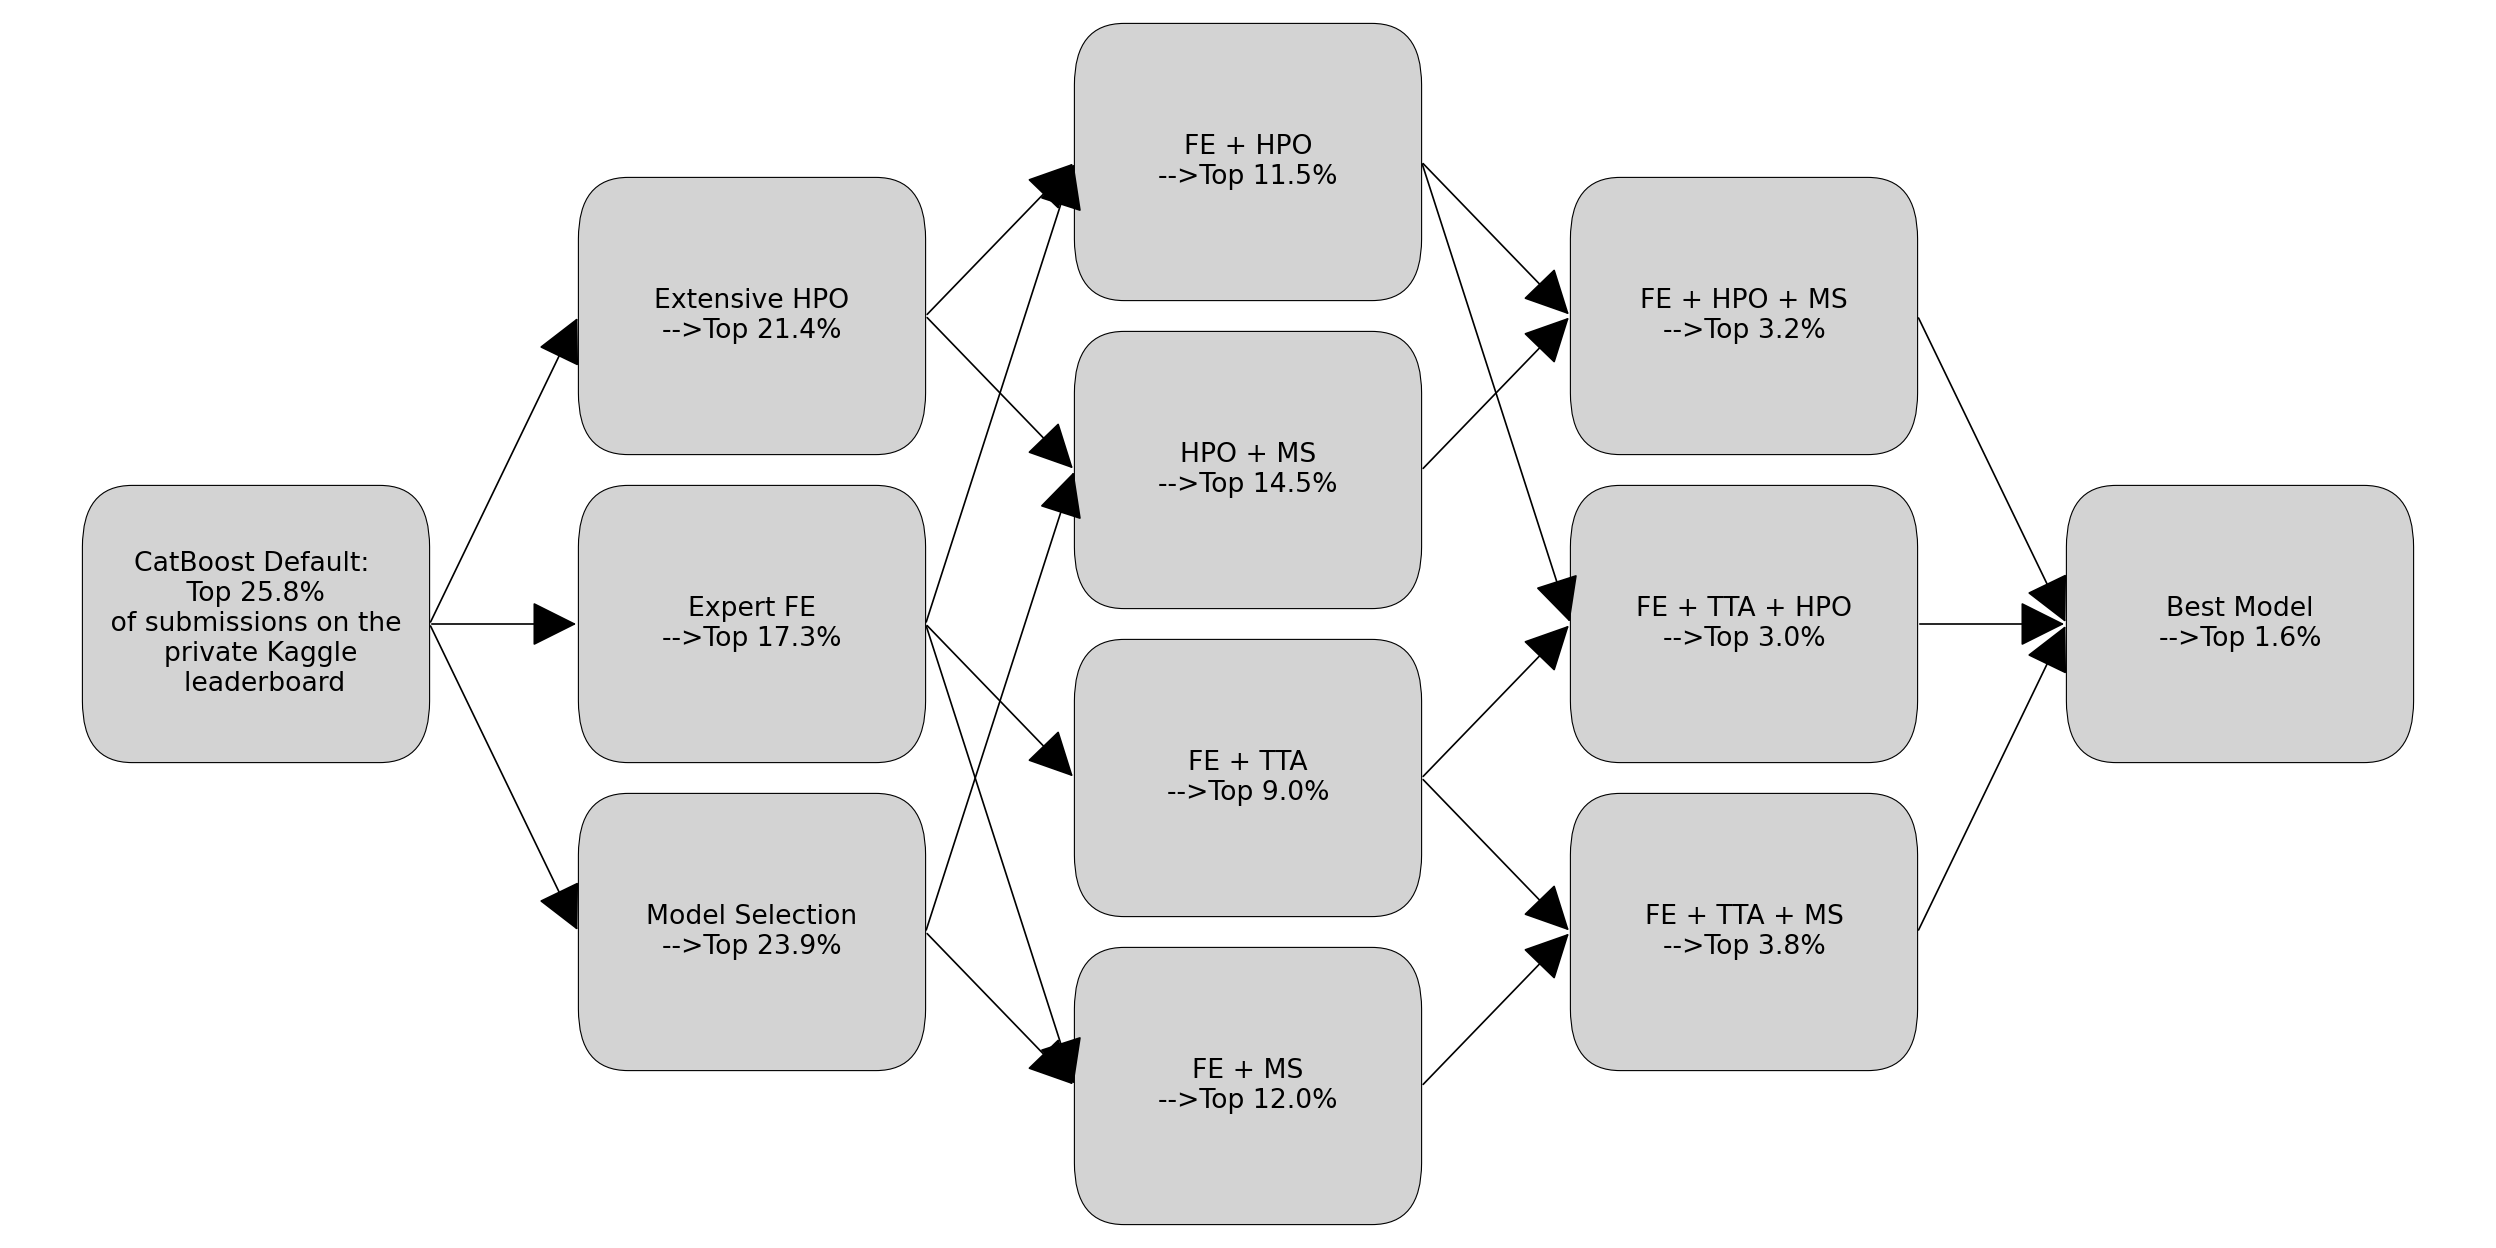

In [38]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
import numpy as np

# Define the font size for the plot
plt.rcParams['font.size'] = 12

# Create the plot with the specified size and DPI
plt.figure(figsize=(40, 20), dpi=80)

# Create a directed graph object
G = nx.DiGraph()

# Add nodes to the graph with specific values and labels
# stds = {}
for node in perf_df.index:
    if node in ["Light HPO", "Expert FE + light HPO", 'Light HPO + Selection', 'Expert FE + TTA + light HPO', 'Expert FE + light HPO + Selection', 'Expert FE + TTA + light HPO + Selection']:
        continue
    G.add_node(node, value=(100 - perf_df.loc[node].mean()).round(1), label=node_map[node])
    # stds[node] = (100 - perf_df.loc[node].std()).round(1)

# Add edges with custom values
edges = [
    ("Default", "Model Selection", 'Select best model'),
    ("Default", "Extensive HPO", 'Extensive HPO'),
    ("Default", "Expert FE", 'Expert FE'),
    ("Model Selection", "Extensive HPO + Selection", 'HPO'),
    ("Model Selection", "Expert FE + Selection", 'Expert FE'),
    ("Expert FE", "Expert FE + TTA", 'TTA'),
    ("Expert FE", "Expert FE + Selection", 'Select best model'),
    ("Expert FE", "Expert FE + extensive HPO", 'Extensive HPO'),
    ("Extensive HPO", "Extensive HPO + Selection", 'Select best model'),
    ("Extensive HPO", "Expert FE + extensive HPO", 'Expert FE'),
    ("Expert FE + extensive HPO", "Expert FE + extensive HPO + Selection", 'Select best model'),
    ("Extensive HPO + Selection", "Expert FE + extensive HPO + Selection", 'Expert FE'),
    ("Expert FE + extensive HPO", "Expert FE + TTA + extensive HPO", 'TTA'),
    ("Expert FE + TTA", "Expert FE + TTA + extensive HPO", 'Extensive HPO'),
    ("Expert FE + TTA", "Expert FE + TTA + Selection", 'Select best model'),
    ("Expert FE + Selection", "Expert FE + TTA + Selection", 'TTA'),
    ("Expert FE + extensive HPO + Selection", "Expert FE + TTA + extensive HPO + Selection", 'TTA'),
    ("Expert FE + TTA + extensive HPO", "Expert FE + TTA + extensive HPO + Selection", 'Select best model'),
    ("Expert FE + TTA + Selection", "Expert FE + TTA + extensive HPO + Selection", 'Extensive HPO')
]

# Add edges to the graph with specific weights and labels
for u, v, label in edges:
    G.add_edge(u, v, weight=(G.nodes[u]["value"] - G.nodes[v]["value"]).round(3), label=label)

# Define the position of nodes
pos = {
    "Default": (0, 0),
    "Expert FE": (1, 0),
    "Model Selection": (1, -0.5),
    "Extensive HPO": (1, 0.5),
    "Expert FE + extensive HPO": (2, 0.75),
    "Extensive HPO + Selection": (2, 0.25),
    "Expert FE + TTA": (2, -0.25),
    "Expert FE + Selection": (2, -0.75),
    "Expert FE + extensive HPO + Selection": (3, 0.5),
    "Expert FE + TTA + extensive HPO": (3, 0),
    "Expert FE + TTA + Selection": (3, -0.5),
    "Expert FE + TTA + extensive HPO + Selection": (4, 0),
}

# Draw nodes as squares with rounded corners
fig, ax = plt.subplots(figsize=(40, 20), dpi=80)

# Define node labels
node_labels = {node: f"{data['label']}\n-->Top {data['value']}%" if data['label']!="Default" else f"CatBoost Default: \n Top {data['value']}% \n of submissions on the \n  private Kaggle \n  leaderboard" for node, data in G.nodes(data=True)}

# Dimensions of the nodes
node_width, node_height = 0.5, 0.25

# Draw nodes with rounded corners and academic color scheme
for node, (x, y) in pos.items():
    box = FancyBboxPatch((x - node_width / 2, y - node_height / 2), node_width, node_height,
                         boxstyle="round,pad=0.1", edgecolor='black', facecolor='lightgrey')
    ax.add_patch(box)
    ax.text(x, y, node_labels[node], horizontalalignment='center', verticalalignment='center', fontsize=24, color='black')

# Function to calculate offset positions for arrows
def get_offset_position(x1, y1, x2, y2, width, height):
    angle = np.arctan2(y2 - y1, x2 - x1)
    dx = width / 2 * np.cos(angle)
    dy = height / 2 * np.sin(angle)
    return x1 + dx, y1 + dy, x2 - dx, y2 - dy

# Draw the edges with annotations
for edge in G.edges(data=True):
    u, v, data = edge
    x1, y1 = pos[u]
    x2, y2 = pos[v]
    ox1, oy1, ox2, oy2 = get_offset_position(x1, y1, x2, y2, node_width, node_height)
    ax.annotate("", xy=(x2-0.35, y2), xytext=(x1+0.35, y1),
                arrowprops=dict(arrowstyle='-|>', color='black', lw=1.5, mutation_scale=90),
                annotation_clip=False)

# Hide the axes
ax.set_xlim(-0.5, 4.5)
ax.set_ylim(-1, 1)
ax.axis('off')

# Save the plot as a PDF file
plt.savefig('figures/mean_gains.pdf', format='pdf', bbox_inches='tight', pad_inches=0)
plt.show()

## D.3: Using Our Framework for Evaluating New Methods

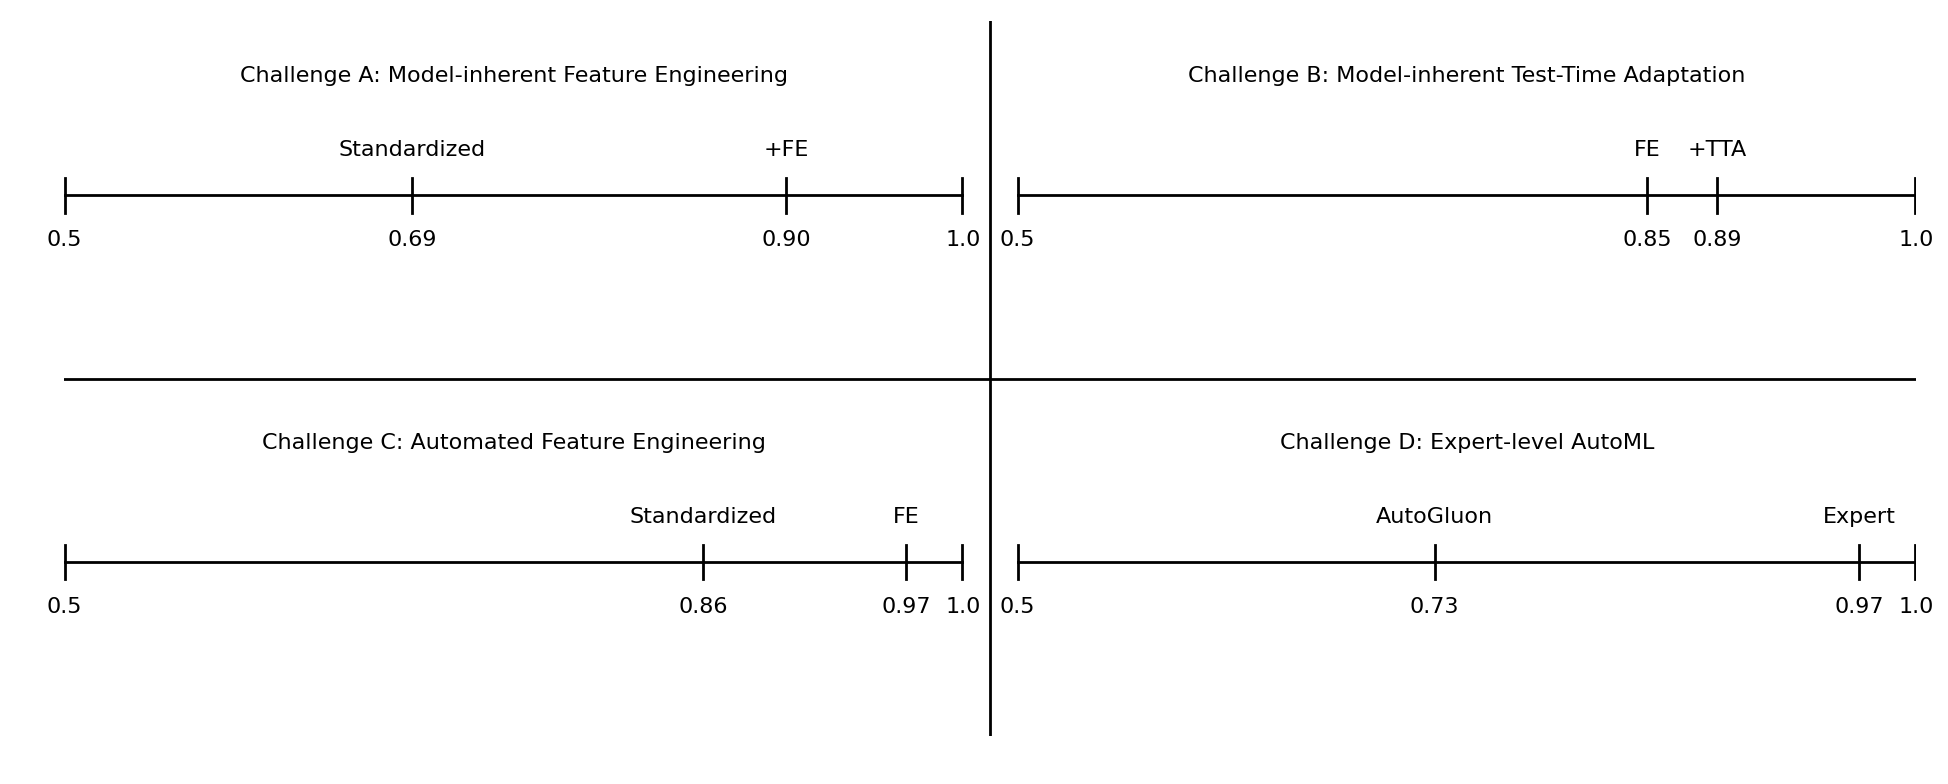

In [39]:
# Set the font to Times New Roman for the entire plot
plt.rcParams['font.serif'] = ['Times New Roman']

# Data for the first plot (FE)
x_markers_1 = [df_min_extensive.loc[:,["FTTransformer", "MLP-PLR", "ResNet","GRANDE"]].max(axis=1).mean(), df_fe_extensive.loc[:,["FTTransformer", "MLP-PLR", "ResNet","GRANDE"]].max(axis=1).mean()]
x_labels_1 = ["Standardized", "+FE"]
x_values_1 = [df_min_extensive.loc[:,["FTTransformer", "MLP-PLR", "ResNet","GRANDE"]].max(axis=1).mean(), df_fe_extensive.loc[:,["FTTransformer", "MLP-PLR", "ResNet","GRANDE"]].max(axis=1).mean()]

# Data for the second plot (TTA)
x_markers_2 = [df_fe_extensive.loc[['AEAC', 'OGPCC', 'SCS', 'SCTP', 'IFD', 'PSSDP'],["FTTransformer", "MLP-PLR", "ResNet","GRANDE"]].max(axis=1).mean(), df_tta_extensive.loc[['AEAC', 'OGPCC', 'SCS', 'SCTP', 'IFD', 'PSSDP'],["FTTransformer", "MLP-PLR", "ResNet","GRANDE"]].max(axis=1).mean()]
# x_markers_2 = [df_fe_extensive.loc[:,["MLP-PLR", "ResNet","GRANDE"]].max(axis=1).mean(), df_tta_extensive.loc[:,["MLP-PLR", "ResNet","GRANDE"]].max(axis=1).mean()]
x_labels_2 = ["FE", "+TTA"]
x_values_2 = [df_fe_extensive.loc[['AEAC', 'OGPCC', 'SCS', 'SCTP', 'IFD', 'PSSDP'],["FTTransformer", "MLP-PLR", "ResNet","GRANDE"]].max(axis=1).mean(), df_tta_extensive.loc[['AEAC', 'OGPCC', 'SCS', 'SCTP', 'IFD', 'PSSDP'],["FTTransformer", "MLP-PLR", "ResNet","GRANDE"]].max(axis=1).mean()]  # Values to show
# x_values_2 = [df_fe_extensive.loc[:,["MLP-PLR", "ResNet","GRANDE"]].max(axis=1).mean(), df_tta_extensive.loc[:,["MLP-PLR", "ResNet","GRANDE"]].max(axis=1).mean()]  # Values to show

# Data for the third plot (Prep)
# x_markers_3 = [df_min_extensive.loc[:,["FTTransformer", "MLP-PLR", "ResNet","GRANDE"]].max(axis=1).mean(), df_fe_extensive.loc[:,["FTTransformer", "MLP-PLR", "ResNet","GRANDE"]].max(axis=1).mean()]
# x_labels_3 = ["Standardized", "FE"]
# x_values_3 = [df_min_extensive.loc[:,["FTTransformer", "MLP-PLR", "ResNet","GRANDE"]].max(axis=1).mean(), df_fe_extensive.loc[:,["FTTransformer", "MLP-PLR", "ResNet","GRANDE"]].max(axis=1).mean()]  # Values to show
x_markers_3 = [df_min_extensive.max(axis=1).mean(), df_fe_extensive.max(axis=1).mean()]
x_labels_3 = ["Standardized", "FE"]
x_values_3 = [df_min_extensive.max(axis=1).mean(), df_fe_extensive.max(axis=1).mean()]  # Values to show

# Data for the second plot (Auto)
x_markers_4 = [df_min_auto.mean(axis=0)["AutoGluon"], df_fe_extensive.max(axis=1).mean()]
x_labels_4 = ["AutoGluon", "Expert"]
x_values_4 = [df_min_auto.mean(axis=0)["AutoGluon"], df_fe_extensive.max(axis=1).mean()]  


# Create a figure with four subplots (2x2 grid)
fig, axs = plt.subplots(2, 2, figsize=(20, 8))  # 2 rows, 2 columns

# Function to plot the data
def plot_data(ax, x_markers, x_labels, x_values, title):
    ax.axhline(y=0, color='black', linestyle='-', linewidth=2)
    ax.axvline(x=0.5003, color='black', linestyle='-', linewidth=2, ymin=0.45, ymax=0.55)
    ax.axvline(x=0.999, color='black', linestyle='-', linewidth=2, ymin=0.45, ymax=0.55)
    ax.text(0.5, -0.1, f'{0.5}', rotation=0, verticalalignment='top', horizontalalignment='center', fontsize=16, color='black')
    ax.text(1, -0.1, f'{1.}', rotation=0, verticalalignment='top', horizontalalignment='center', fontsize=16, color='black')
    ax.axvline(x=x_markers[0], color='black', linestyle='-', linewidth=2, ymin=0.45, ymax=0.55)
    ax.axvline(x=x_markers[1], color='black', linestyle='-', linewidth=2, ymin=0.45, ymax=0.55)
    for i, (x, label, value) in enumerate(zip(x_markers, x_labels, x_values)):
        ax.text(x, 0.1, label, rotation=0, verticalalignment='bottom', horizontalalignment='center', fontsize=16)
        ax.text(x, -0.1, f'{value:.2f}', rotation=0, verticalalignment='top', horizontalalignment='center', fontsize=16, color='black')
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_ylim(-0.5, 0.5)
    ax.set_xlim(0.5, 1)
    # ax.invert_xaxis()
    ax.tick_params(axis='x', direction='out', length=10, width=2, colors='black', grid_color='black', grid_alpha=0.5)
    ax.set_title(title, fontsize=16, y=0.8)

# First subplot (top-left)
plot_data(axs[0, 0], x_markers_1, x_labels_1, x_values_1, "Challenge A: Model-inherent Feature Engineering")

# Second subplot (top-right)
plot_data(axs[0, 1], x_markers_2, x_labels_2, x_values_2, "Challenge B: Model-inherent Test-Time Adaptation")

# Third subplot (bottom-left)
plot_data(axs[1, 0], x_markers_3, x_labels_3, x_values_3, "Challenge C: Automated Feature Engineering")

# Fourth subplot (bottom-right)
plot_data(axs[1, 1], x_markers_4, x_labels_4, x_values_4, "Challenge D: Expert-level AutoML")

# Add horizontal and vertical lines to separate the subplots
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

# Add horizontal line
plt.axhline(0.5, color='black', linestyle='-', linewidth=2, xmin=0, xmax=1)

# Add vertical line
plt.axvline(0.5, color='black', linestyle='-', linewidth=2, ymin=0, ymax=1)

# Adjust layout to make the plot narrower
plt.subplots_adjust(top=0.5, bottom=0.1, hspace=0.5, wspace=0.3)  # Adjust hspace and wspace to add space between plots


# Adjust layout for better spacing
plt.tight_layout()

plt.savefig('figures/challenges.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

# Display the combined plot
plt.show()